In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)


# Utility

In [33]:
def barplot(df):
    # Calculate the sum of null values in each column and convert to percentage
    total_rows = len(df)
    null_counts = (df.isnull().sum() / total_rows) * 100

    # Generate different colors for each column
    colors = plt.cm.viridis(np.linspace(0, 1, len(null_counts)))

    # Create a horizontal bar plot
    plt.figure(figsize=(20, 20))
    null_counts.sort_values(ascending=True).plot(kind='barh', color=colors)
    plt.title('Percentage of Null Values in df Columns')
    plt.xlabel('Percentage of Null Values')
    plt.ylabel('Columns')
    plt.xticks(fontsize=10)  # Adjust font size here (e.g., fontsize=10)
    plt.xlim(0, 100)  # Set x-axis limit to 0-100 for percentages
    plt.tight_layout()
    plt.show()

In [34]:
def drop_columns_with_nulls_over_threshold(df, threshold=50.0):
    """
    Drop columns from the DataFrame where the percentage of NaN values is greater than the specified threshold.

    Parameters:
    df (DataFrame): The input DataFrame.
    threshold (float): The threshold percentage of NaN values to drop the columns.

    Returns:
    DataFrame: A DataFrame with the specified columns dropped.
    list: A list of columns that were dropped.
    """
    # Calculate the number of NaNs and the percentage for each column
    col_na = df.isnull().sum()
    percent = (col_na / len(df)) * 100

    # Create a DataFrame with the counts and percentages
    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])

    # Find columns where the percentage of NaNs is greater than the threshold
    cols_to_drop = missing_data[missing_data['Percent'] > threshold].index

    # Drop these columns
    df_dropped = df.drop(columns=cols_to_drop)

    # Return the DataFrame with the columns dropped and the list of dropped columns
    return df_dropped, cols_to_drop


In [35]:
# mengecek nilai null
def check_null(df):
    col_na = df.isnull().sum().sort_values(ascending=False)
    percent = col_na / len(df) * 100

    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data[missing_data['Total'] > 0])


# Load Data and Preprocessing

In [37]:
train_df = pd.read_csv('./EuropeanInvestmentManagement_train.csv')
train_df.drop(['ticker'], axis=1,inplace=True)
test_df = pd.read_csv('./EuropeanInvestmentManagement_test_classification.csv')
test_df.drop(['ticker'], axis=1,inplace=True)

In [38]:
train_df['rating'].value_counts()

rating
3.0    8226
4.0    5841
2.0    4138
5.0    2847
1.0    1368
Name: count, dtype: int64

In [36]:
train_df.head()

,category,dividend_frequency,equity_style,equity_size,equity_size_score,price_prospective_earnings,price_book_ratio,price_sales_ratio,price_cash_flow_ratio,dividend_yield_factor,long_term_projected_earnings_growth,historical_earnings_growth,sales_growth,cash_flow_growth,book_value_growth,roa,roe,roic,bond_interest_rate_sensitivity,bond_credit_quality,average_coupon_rate,average_credit_quality,modified_duration,effective_maturity,asset_stock,asset_bond,asset_cash,asset_other,sector_basic_materials,sector_consumer_cyclical,sector_financial_services,sector_real_estate,sector_consumer_defensive,sector_healthcare,sector_utilities,sector_communication_services,sector_energy,sector_industrials,sector_technology,market_cap_giant,market_cap_large,market_cap_medium,market_cap_small,market_cap_micro,credit_aaa,credit_aa,credit_a,credit_bbb,credit_bb,credit_b,credit_below_b,credit_not_rated,holdings_n_stock,holdings_n_bonds,ongoing_cost,management_fees,environmental_score,social_score,governance_score,sustainability_score,sustainability_rank,sustainability_percentage_rank,involvement_abortive_contraceptive,involvement_alcohol,involvement_animal_testing,involvement_controversial_weapons,involvement_gambling,involvement_gmo,involvement_military_contracting,involvement_nuclear,involvement_palm_oil,involvement_pesticides,involvement_small_arms,involvement_thermal_coal,involvement_tobacco,nav_per_share_currency,nav_per_share,shareclass_size_currency,shareclass_size,fund_size_currency,fund_size,fund_trailing_return_ytd,fund_trailing_return_3years,fund_trailing_return_5years,fund_trailing_return_10years,fund_return_2019,fund_return_2018,fund_return_2017,fund_return_2016,fund_return_2015,fund_return_2020_q3,fund_return_2020_q2,fund_return_2020_q1,fund_return_2019_q4,fund_return_2019_q3,fund_return_2019_q2,fund_return_2019_q1,fund_return_2018_q4,fund_return_2018_q3,fund_return_2018_q2,fund_return_2018_q1,fund_return_2017_q4,fund_return_2017_q3,fund_return_2017_q2,fund_return_2017_q1,fund_return_2016_q4,fund_return_2016_q3,fund_return_2016_q2,fund_return_2016_q1,fund_return_2015_q4,fund_return_2015_q3,fund_return_2015_q2,fund_return_2015_q1,quarters_up,quarters_down,rating
0,Global Flex-Cap Equity,NaN,Value,Large,248.25,10.66,1.00,0.92,6.19,4.13,8.66,3.06,4.72,0.16,2.75,6.38,14.04,11.80,NaN,NaN,NaN,NaN,NaN,NaN,98.55,0.00,1.45,0.00,14.17,2.35,18.69,NaN,4.31,9.30,NaN,9.28,7.74,23.95,10.21,30.75,39.04,16.80,10.69,2.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN,NaN,NaN,6.16,8.72,8.73,24.38,1.0,89.0,9.67,2.86,11.77,0.00,0.00,0.00,0.00,1.37,0.0,0.00,0.00,0.00,0.00,GBP,241.84,NOK,261930000.0,NOK,6.566210e+09,1.40,2.08,10.28,NaN,18.51,-11.31,15.24,28.74,NaN,5.66,18.05,-24.50,2.42,-0.41,8.18,7.40,-14.03,5.37,5.56,-7.25,3.53,1.79,1.95,7.25,6.06,14.75,1.85,3.86,8.01,-8.18,-4.63,NaN,16,6,3.0
1,US Mid-Cap Equity,Annually,Blend,Medium,124.69,23.06,1.97,1.70,12.07,1.30,9.34,14.30,7.55,8.56,9.59,7.36,14.61,11.33,NaN,NaN,NaN,NaN,NaN,NaN,96.81,0.57,2.63,-0.01,8.17,14.42,18.82,NaN,2.96,15.34,1.59,NaN,NaN,17.32,21.39,1.14,0.00,66.33,32.53,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,1.0,0.8400,0.75,5.31,8.85,7.16,26.08,2.0,78.0,3.93,0.00,14.93,0.00,0.00,0.00,4.91,0.00,0.0,2.38,0.00,1.59,0.00,USD,3.96,USD,17010000.0,USD,7.717900e+08,1.65,6.66,12.09,NaN,25.39,-5.72,1.74,41.98,7.12,0.89,17.82,-24.09,0.12,4.68,8.60,10.16,-16.02,6.56,11.32,-5.35,5.29,-1.81,-1.71,0.12,11.94,8.64,9.40,6.72,9.26,-6.20,-4.92,9.93,16,7,3.0
2,Asia-Pacific ex-Japan Equity,Annually,Growth,Large,322.70,27.99,3.04,2.71,10.35,0.97,16.87,NaN,13.80,21.53,14.76,7.83,16.35,11.62,NaN,NaN,NaN,NaN,NaN,NaN,95.92,0.00,2.21,1.87,6.35,22.32,10.82,0.44,11.74,3.37,NaN,17.14,NaN,4.39,23.42,62.38,21.08,11.85,3.33,1.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,1.0182,0.75,4.23,8.38,6.99,24.98,4.0,44.0,0.26,0.00,2.83,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,GBP,2.32,GBP,30900000.0,GBP,1.282800e+08,45.43,13.19,18.48,7.76,22.29,-19.51,29.12,24.70,-5.99,17.13,27.23,-9.07,6.64,1.42,3.90,8.82,-7.94,-7.33,4.11,-9.37,9.92

In [37]:
train_df.shape

(22420, 116)

In [12]:
check_null(train_df)

                                    Total    Percent
modified_duration                   20692  92.292596
effective_maturity                  20529  91.565566
bond_credit_quality                 20133  89.799286
bond_interest_rate_sensitivity      20133  89.799286
credit_a                            19897  88.746655
credit_bbb                          19897  88.746655
credit_b                            19897  88.746655
credit_below_b                      19897  88.746655
credit_not_rated                    19897  88.746655
credit_bb                           19897  88.746655
credit_aa                           19897  88.746655
credit_aaa                          19897  88.746655
average_credit_quality              19894  88.733274
holdings_n_bonds                    18291  81.583408
average_coupon_rate                 16351  72.930419
fund_trailing_return_10years        12422  55.405888
dividend_frequency                  11985  53.456735
fund_return_2015                     6604  29.

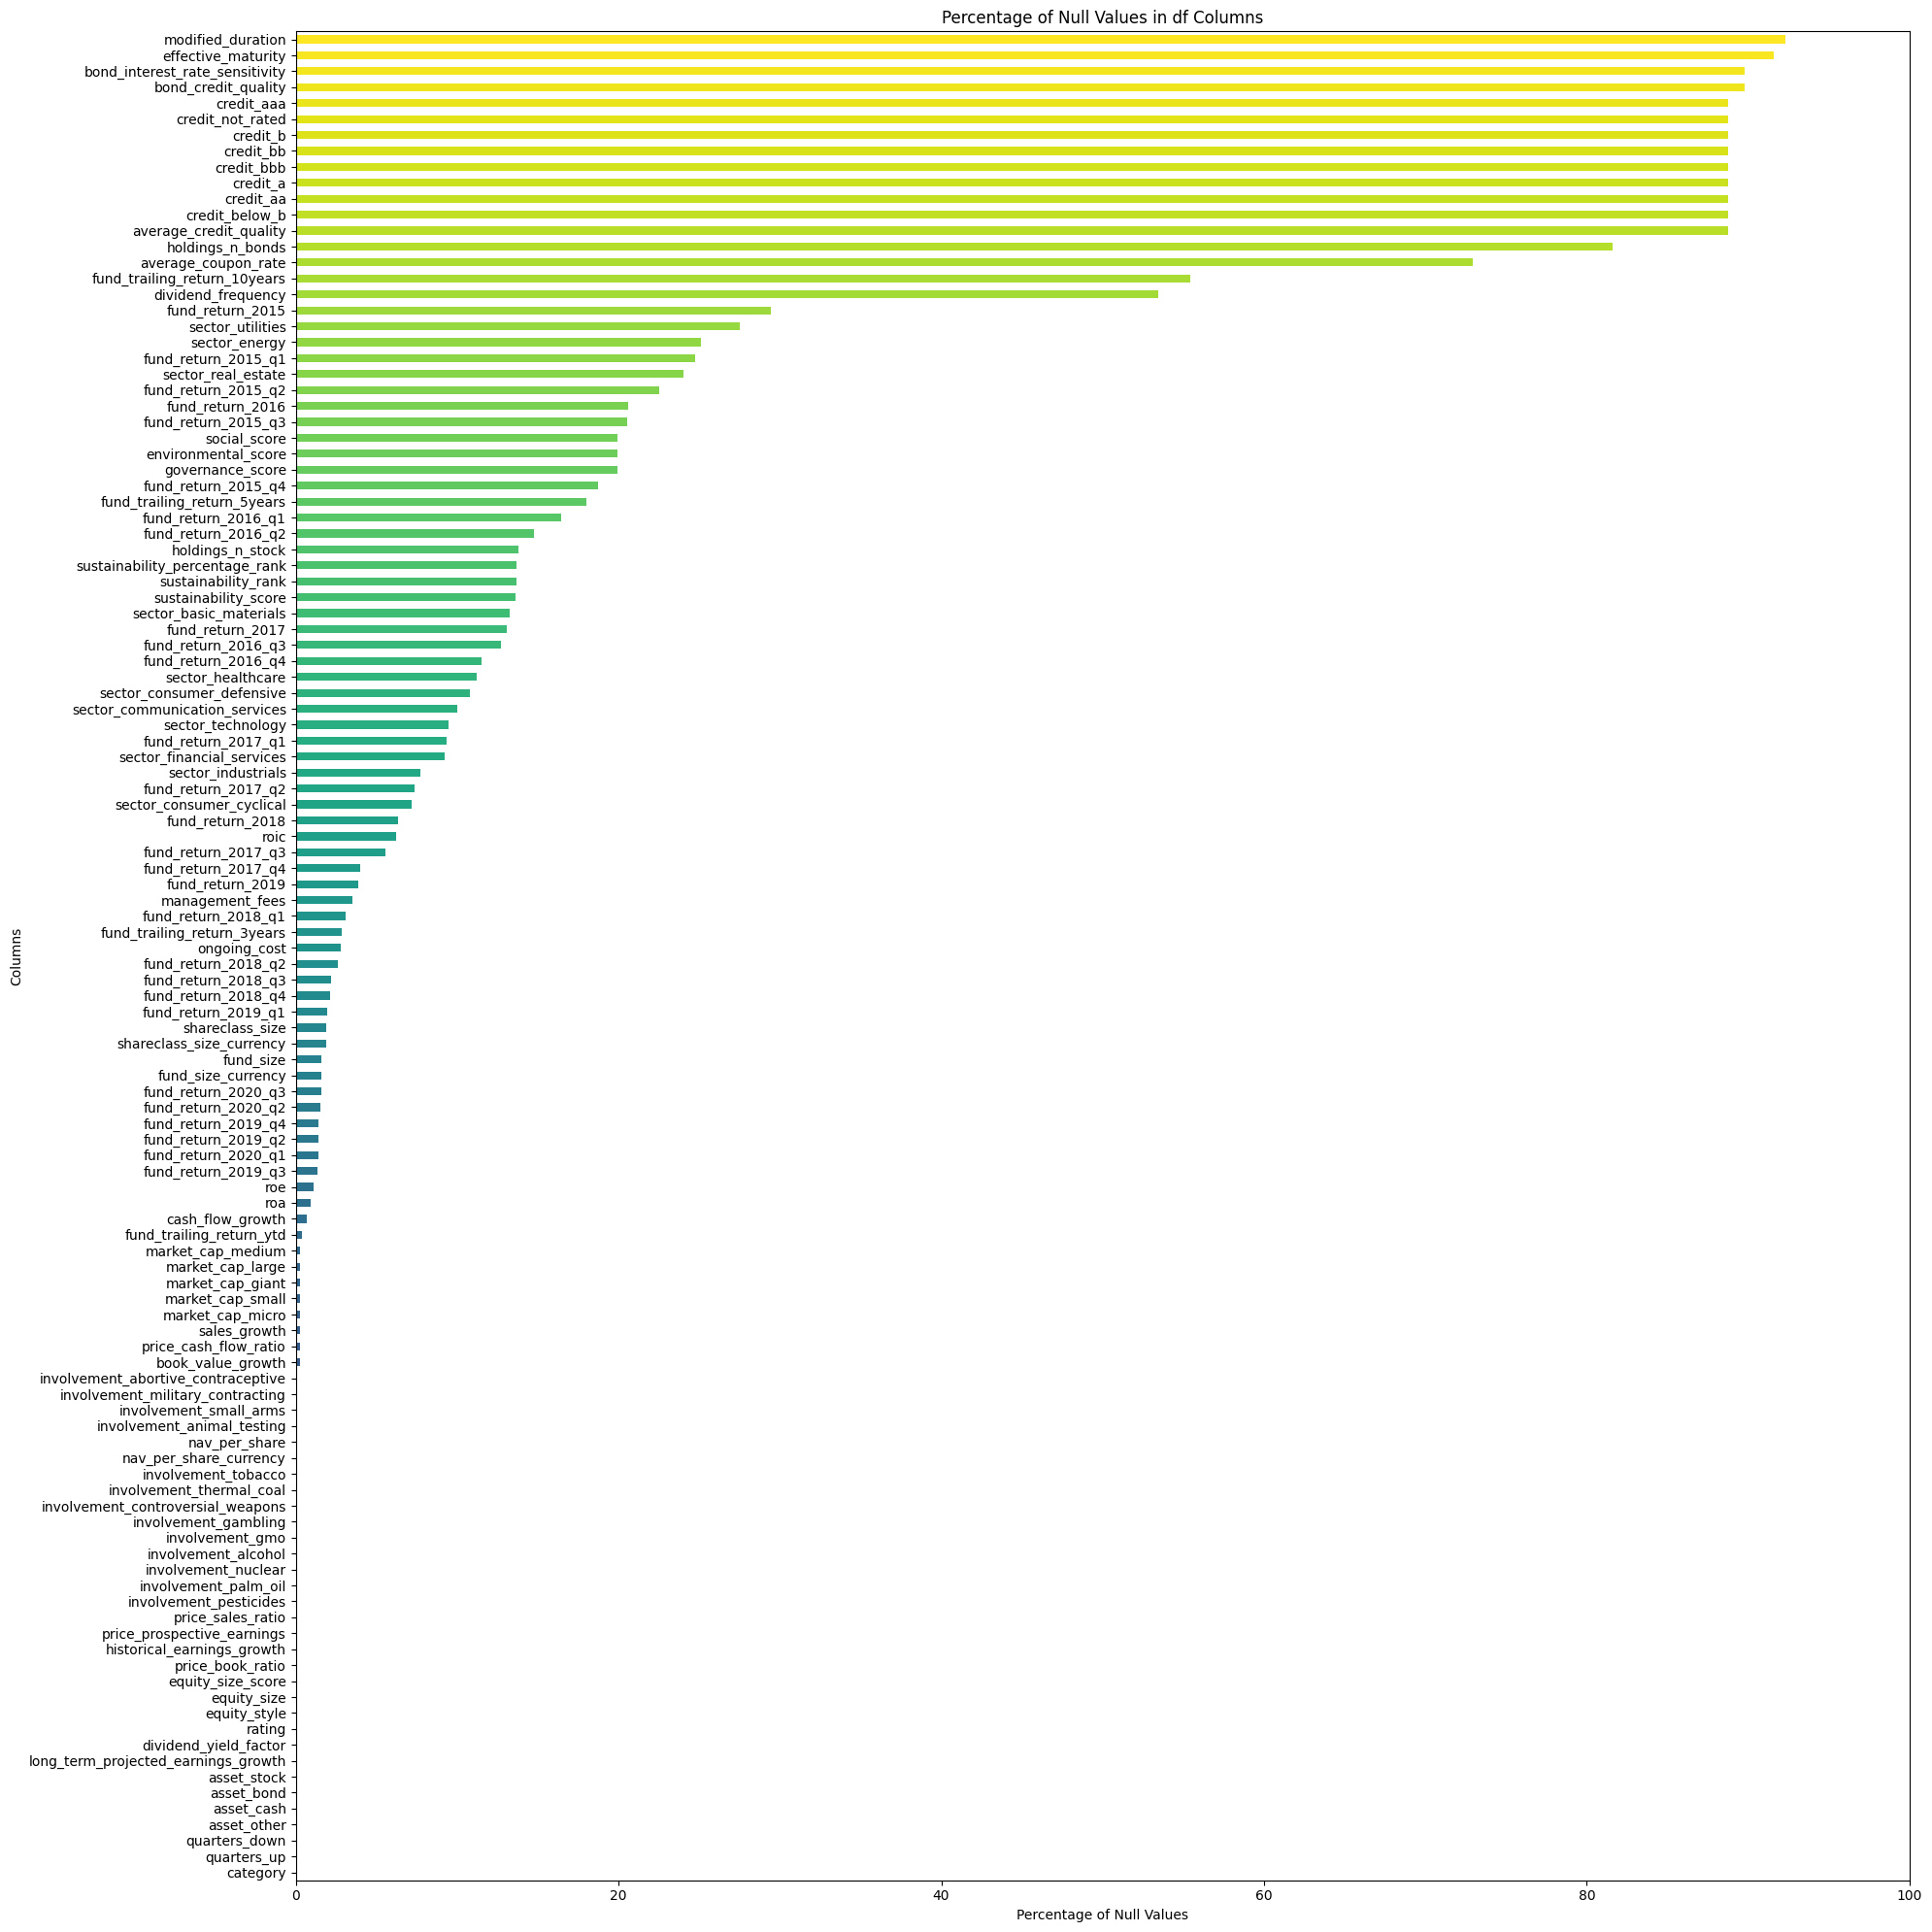

In [13]:
barplot(train_df)

Because of the amount of percentage of some column is over than 50%. Which is not little, then we drop the column

In [39]:
dropped_train_df, columns_to_drop = drop_columns_with_nulls_over_threshold(train_df)

In [40]:
dropped_test_df = test_df.drop(columns=columns_to_drop, axis=True)

In [41]:
dropped_test_df.shape

(2802, 98)

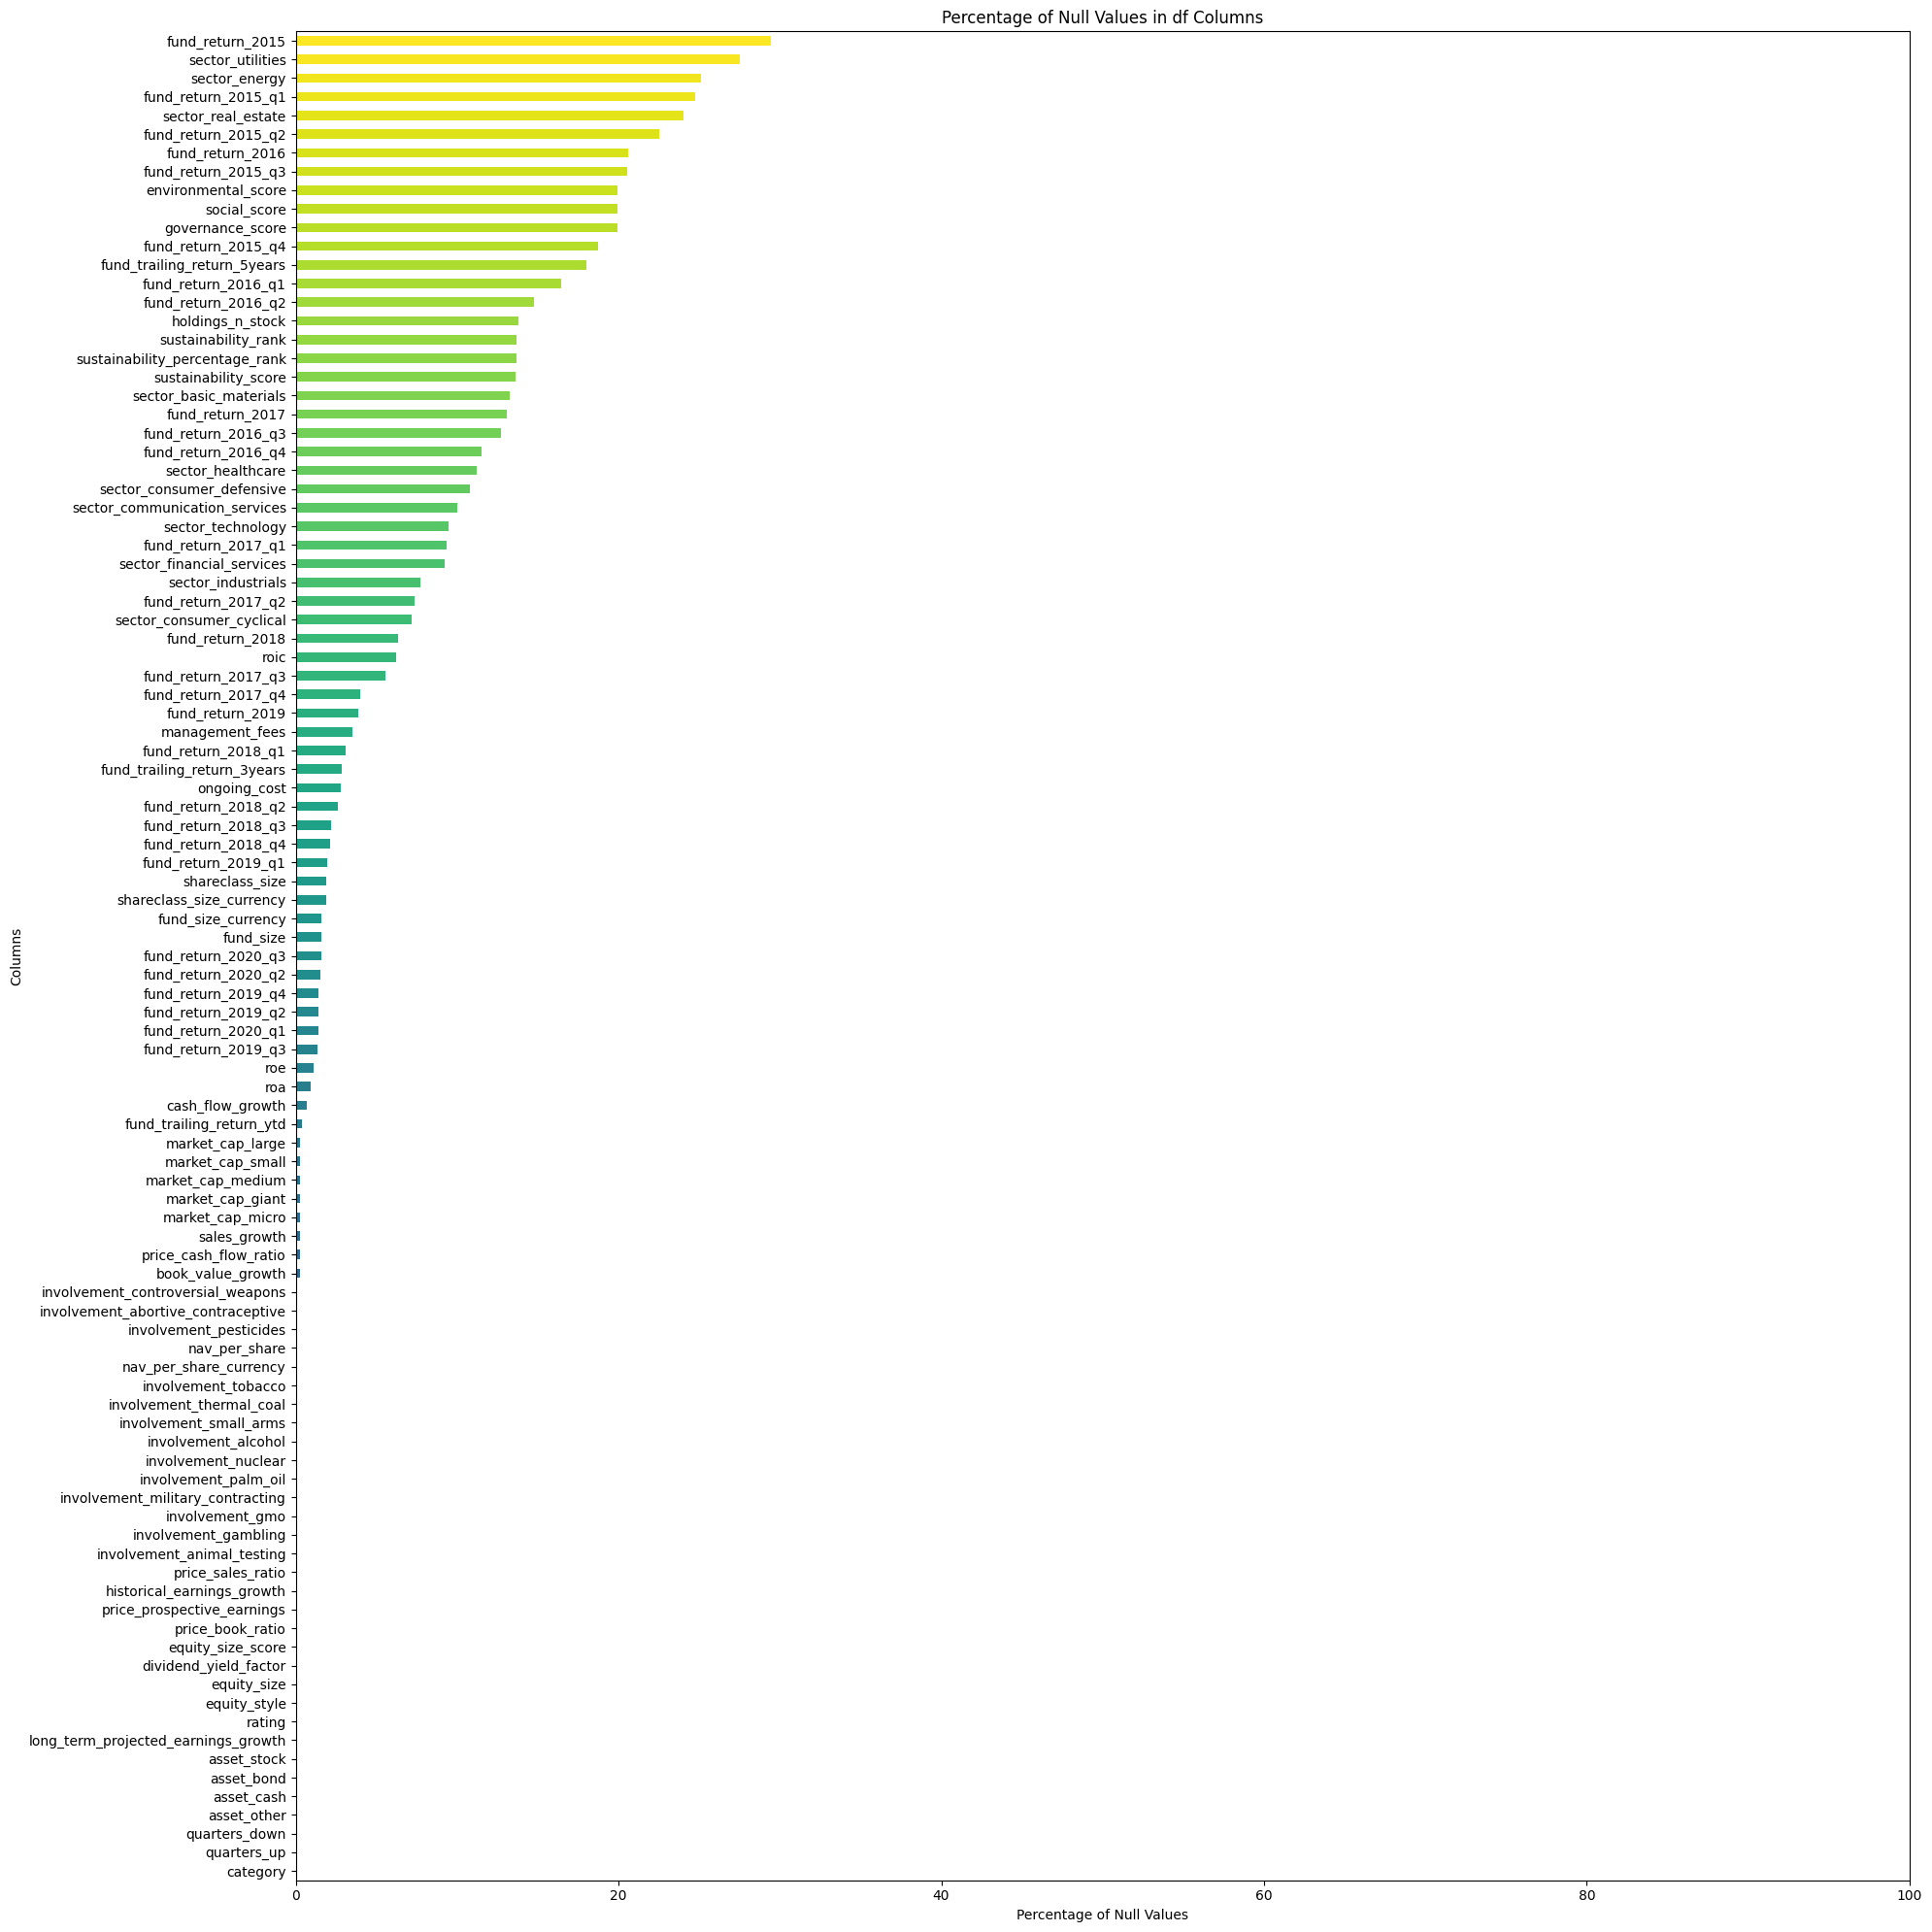

In [15]:
barplot(dropped_train_df)

# Encoding Categorical Feature

Using ordinal encoder to encode categorical column with the mean order of 'rating'

In [118]:
test_df.head()

,ticker,category,dividend_frequency,equity_style,equity_size,equity_size_score,price_prospective_earnings,price_book_ratio,price_sales_ratio,price_cash_flow_ratio,dividend_yield_factor,long_term_projected_earnings_growth,historical_earnings_growth,sales_growth,cash_flow_growth,book_value_growth,roa,roe,roic,bond_interest_rate_sensitivity,bond_credit_quality,average_coupon_rate,average_credit_quality,modified_duration,effective_maturity,asset_stock,asset_bond,asset_cash,asset_other,sector_basic_materials,sector_consumer_cyclical,sector_financial_services,sector_real_estate,sector_consumer_defensive,sector_healthcare,sector_utilities,sector_communication_services,sector_energy,sector_industrials,sector_technology,market_cap_giant,market_cap_large,market_cap_medium,market_cap_small,market_cap_micro,credit_aaa,credit_aa,credit_a,credit_bbb,credit_bb,credit_b,credit_below_b,credit_not_rated,holdings_n_stock,holdings_n_bonds,ongoing_cost,management_fees,environmental_score,social_score,governance_score,sustainability_score,sustainability_rank,sustainability_percentage_rank,involvement_abortive_contraceptive,involvement_alcohol,involvement_animal_testing,involvement_controversial_weapons,involvement_gambling,involvement_gmo,involvement_military_contracting,involvement_nuclear,involvement_palm_oil,involvement_pesticides,involvement_small_arms,involvement_thermal_coal,involvement_tobacco,nav_per_share_currency,nav_per_share,shareclass_size_currency,shareclass_size,fund_size_currency,fund_size,fund_trailing_return_ytd,fund_trailing_return_3years,fund_trailing_return_5years,fund_trailing_return_10years,fund_return_2019,fund_return_2018,fund_return_2017,fund_return_2016,fund_return_2015,fund_return_2020_q3,fund_return_2020_q2,fund_return_2020_q1,fund_return_2019_q4,fund_return_2019_q3,fund_return_2019_q2,fund_return_2019_q1,fund_return_2018_q4,fund_return_2018_q3,fund_return_2018_q2,fund_return_2018_q1,fund_return_2017_q4,fund_return_2017_q3,fund_return_2017_q2,fund_return_2017_q1,fund_return_2016_q4,fund_return_2016_q3,fund_return_2016_q2,fund_return_2016_q1,fund_return_2015_q4,fund_return_2015_q3,fund_return_2015_q2,fund_return_2015_q1,quarters_up,quarters_down
0,F00000ZI14,Global Large-Cap Blend Equity,Annually,Blend,Large,268.51,18.85,2.48,1.35,8.13,2.48,8.20,6.90,4.74,5.15,6.39,10.05,26.31,16.61,NaN,NaN,NaN,NaN,NaN,NaN,99.85,0.00,-0.98,1.13,1.15,11.59,10.51,2.97,2.99,18.83,0.06,10.92,0.36,14.89,25.72,38.68,35.03,26.22,0.07,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,NaN,1.15,0.80,2.95,10.19,7.70,20.84,4.0,16.0,7.30,0.00,19.14,0.23,0.31,0.00,0.44,0.22,0.00,0.00,0.01,0.03,0.01,USD,12.29,USD,5440000.0,USD,112390000.0,7.25,6.76,NaN,NaN,19.77,-6.22,NaN,NaN,NaN,2.92,16.56,-13.46,1.28,3.42,5.01,8.90,-13.37,4.76,8.35,-4.62,4.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,3
1,F00000Z00F,GBP Flexible Allocation,Annually,Blend,Large,306.01,22.41,2.35,1.72,9.87,2.16,10.00,6.60,5.46,5.39,6.22,8.33,23.29,13.39,High,High,2.69,3.0,14.73,12.46,81.45,15.31,3.23,0.01,8.07,22.45,13.90,1.29,4.05,11.29,1.29,5.78,1.34,4.07,26.48,53.33,33.39,13.22,0.06,0.00,63.15,36.84,0.0,0.0,0.0,0.0,0.0,0.01,NaN,NaN,0.84,0.70,4.36,10.30,7.86,22.67,4.0,28.0,4.15,0.69,9.75,2.47,0.49,0.05,3.15,0.71,0.08,0.28,1.21,0.91,0.27,GBX,115.77,GBP,4550000.0,GBP,8820000.0,3.11,3.92,NaN,NaN,11.90,-6.01,NaN,NaN,NaN,4.30,8.23,-14.01,2.58,2.16,4.22,2.46,-9.15,4.66,3.02,-4.06,7.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,3
2,F0GBR04LI4,Europe ex-UK Equity,Annually,Blend,Large,237.10,13.28,1.32,0.94,3.74,3.97,8.60,1.81,1.83,10.77,1.92,8.47,18.40,15.66,NaN,NaN,NaN,NaN,NaN,NaN,96.27,0.00,3.73,0.00,6.04,6.70,13.95,2.20,13.00,20.32,7.62,4.52,0.33,16.33,9.00,36.73,31.76,15.79,14.56,1.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.0,NaN,1.65,0.00,4.10,7.89,7.34,20.92,3.0,40.0,16.47,4.80,31.09,0.00,0.00,0.00,0.00,5.50,0.00,0.10,0.00,1.61,0.13,GBP,2.44,GBP,21810000.0,GBP,32830000.0,2.10,-1.05,5.09,5.90,17.08,-20.17,14.24,14.91,2.86,1.07,21.20,-19.50,1.27,-0.63,9.62,6.14,-12.76,-0.30,-2.34,-6.03,0.77,0

In [107]:
train_df['ticker'].isnull().sum()

0

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

# Combine 'ticker' and 'category' data for both training and test data
combined_category_data = pd.concat([dropped_train_df[['category', 'rating']], dropped_test_df[['category']]], axis=0)

# Get sorted unique categories based on mean 'rating'
category_mean_ratings = combined_category_data.groupby('category')['rating'].mean().sort_values(ascending=True).index.tolist()

# Add a catch-all category for unknown values
category_mean_ratings = [np.nan] + category_mean_ratings


# Encode 'category' based on sorted unique categories for both training and test data
category_enc = OrdinalEncoder(categories=[category_mean_ratings])
combined_category_data_encoded = category_enc.fit_transform(combined_category_data[['category']].values)

# Update the original DataFrames in both training and test data with the encoded values
dropped_train_df['category'] = combined_category_data_encoded[:len(dropped_train_df)]
dropped_test_df['category'] = combined_category_data_encoded[len(dropped_train_df):]


In [43]:
# Possible to rearrange
equity_style_group = [np.nan] + dropped_train_df.groupby(by='equity_style')['rating'].mean().sort_values(ascending=True).index.tolist()
equity_size_group = [np.nan] + dropped_train_df.groupby(by='equity_size')['rating'].mean().sort_values(ascending=True).index.tolist()
nav_per_share_currency_group = [np.nan] + dropped_train_df.groupby(by='nav_per_share_currency')['rating'].mean().sort_values(ascending=True).index.tolist()
shareclass_size_currency_group = [np.nan] + dropped_train_df.groupby(by='shareclass_size_currency')['rating'].mean().sort_values(ascending=True).index.tolist()
fund_size_currency_group = [np.nan] + dropped_train_df.groupby(by='fund_size_currency')['rating'].mean().sort_values(ascending=True).index.tolist()

column_to_encode = ['equity_style','equity_size', 'nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency']

enc = OrdinalEncoder(categories=[equity_style_group, equity_size_group, nav_per_share_currency_group, shareclass_size_currency_group, fund_size_currency_group])
dropped_train_df[column_to_encode] = enc.fit_transform(dropped_train_df[column_to_encode])
dropped_test_df[column_to_encode] = enc.transform(dropped_test_df[column_to_encode])


In [14]:
dropped_test_df.head()

,ticker,category,equity_style,equity_size,equity_size_score,price_prospective_earnings,price_book_ratio,price_sales_ratio,price_cash_flow_ratio,dividend_yield_factor,long_term_projected_earnings_growth,historical_earnings_growth,sales_growth,cash_flow_growth,book_value_growth,roa,roe,roic,asset_stock,asset_bond,asset_cash,asset_other,sector_basic_materials,sector_consumer_cyclical,sector_financial_services,sector_real_estate,sector_consumer_defensive,sector_healthcare,sector_utilities,sector_communication_services,sector_energy,sector_industrials,sector_technology,market_cap_giant,market_cap_large,market_cap_medium,market_cap_small,market_cap_micro,holdings_n_stock,ongoing_cost,management_fees,environmental_score,social_score,governance_score,sustainability_score,sustainability_rank,sustainability_percentage_rank,involvement_abortive_contraceptive,involvement_alcohol,involvement_animal_testing,involvement_controversial_weapons,involvement_gambling,involvement_gmo,involvement_military_contracting,involvement_nuclear,involvement_palm_oil,involvement_pesticides,involvement_small_arms,involvement_thermal_coal,involvement_tobacco,nav_per_share_currency,nav_per_share,shareclass_size_currency,shareclass_size,fund_size_currency,fund_size,fund_trailing_return_ytd,fund_trailing_return_3years,fund_trailing_return_5years,fund_return_2019,fund_return_2018,fund_return_2017,fund_return_2016,fund_return_2015,fund_return_2020_q3,fund_return_2020_q2,fund_return_2020_q1,fund_return_2019_q4,fund_return_2019_q3,fund_return_2019_q2,fund_return_2019_q1,fund_return_2018_q4,fund_return_2018_q3,fund_return_2018_q2,fund_return_2018_q1,fund_return_2017_q4,fund_return_2017_q3,fund_return_2017_q2,fund_return_2017_q1,fund_return_2016_q4,fund_return_2016_q3,fund_return_2016_q2,fund_return_2016_q1,fund_return_2015_q4,fund_return_2015_q3,fund_return_2015_q2,fund_return_2015_q1,quarters_up,quarters_down
0,24633.0,148.0,2.0,3.0,268.51,18.85,2.48,1.35,8.13,2.48,8.20,6.90,4.74,5.15,6.39,10.05,26.31,16.61,99.85,0.00,-0.98,1.13,1.15,11.59,10.51,2.97,2.99,18.83,0.06,10.92,0.36,14.89,25.72,38.68,35.03,26.22,0.07,0.00,192.0,1.15,0.80,2.95,10.19,7.70,20.84,4.0,16.0,7.30,0.00,19.14,0.23,0.31,0.00,0.44,0.22,0.00,0.00,0.01,0.03,0.01,13.0,12.29,13.0,5440000.0,10.0,112390000.0,7.25,6.76,NaN,19.77,-6.22,NaN,NaN,NaN,2.92,16.56,-13.46,1.28,3.42,5.01,8.90,-13.37,4.76,8.35,-4.62,4.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,3
1,24587.0,61.0,2.0,3.0,306.01,22.41,2.35,1.72,9.87,2.16,10.00,6.60,5.46,5.39,6.22,8.33,23.29,13.39,81.45,15.31,3.23,0.01,8.07,22.45,13.90,1.29,4.05,11.29,1.29,5.78,1.34,4.07,26.48,53.33,33.39,13.22,0.06,0.00,NaN,0.84,0.70,4.36,10.30,7.86,22.67,4.0,28.0,4.15,0.69,9.75,2.47,0.49,0.05,3.15,0.71,0.08,0.28,1.21,0.91,0.27,6.0,115.77,9.0,4550000.0,8.0,8820000.0,3.11,3.92,NaN,11.90,-6.01,NaN,NaN,NaN,4.30,8.23,-14.01,2.58,2.16,4.22,2.46,-9.15,4.66,3.02,-4.06,7.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,3
2,24913.0,85.0,2.0,3.0,237.10,13.28,1.32,0.94,3.74,3.97,8.60,1.81,1.83,10.77,1.92,8.47,18.40,15.66,96.27,0.00,3.73,0.00,6.04,6.70,13.95,2.20,13.00,20.32,7.62,4.52,0.33,16.33,9.00,36.73,31.76,15.79,14.56,1.17,128.0,1.65,0.00,4.10,7.89,7.34,20.92,3.0,40.0,16.47,4.80,31.09,0.00,0.00,0.00,0.00,5.50,0.00,0.10,0.00,1.61,0.13,7.0,2.44,9.0,21810000.0,8.0,32830000.0,2.10,-1.05,5.09,17.08,-20.17,14.24,14.91,2.86,1.07,21.20,-19.50,1.27,-0.63,9.62,6.14,-12.76,-0.30,-2.34,-6.03,0.77,0.29,6.31,6.32,9.88,7.04,-1.51,-0.80,5.64,-6.99,-4.08,9.14,13,10
3,24419.0,50.0,1.0,1.0,32.58,13.85,1.12,0.75,5.14,2.78,10.77,5.18,3.46,9.02,5.97,2.26,5.72,4.57,99.17,0.00,0.83,0.00,7.44,18.98,19.70,11.50,2.50,6.33,0.35,NaN,3.10,19.81,10.28,0.00,0.00,10.31,60.69,29.00,147.0,0.95,0.85,NaN,NaN,NaN,26.63,3.0,22.0,0.77,0.00,2.36,0.88,0.00,0.00,0.88,0.00,0.00,0.29,0.00,0.00,0.67,13.0,130.23,13.0,17940000.0,10.0,18070000.0,-7.73,-1.66,NaN,16.74,-12.16,1.19,NaN,NaN,-2.50,17.88,-31.64,2.66,1.96,3.59,7.65,-16.92,0.22,13.70,-7.21,2.73,2.49,-1.37,-2.56,20.38,13.93,NaN,NaN,NaN,NaN,NaN,NaN,11,6
4,24885.

In [15]:
dropped_train_df.head()

,ticker,category,equity_style,equity_size,equity_size_score,price_prospective_earnings,price_book_ratio,price_sales_ratio,price_cash_flow_ratio,dividend_yield_factor,long_term_projected_earnings_growth,historical_earnings_growth,sales_growth,cash_flow_growth,book_value_growth,roa,roe,roic,asset_stock,asset_bond,asset_cash,asset_other,sector_basic_materials,sector_consumer_cyclical,sector_financial_services,sector_real_estate,sector_consumer_defensive,sector_healthcare,sector_utilities,sector_communication_services,sector_energy,sector_industrials,sector_technology,market_cap_giant,market_cap_large,market_cap_medium,market_cap_small,market_cap_micro,holdings_n_stock,ongoing_cost,management_fees,environmental_score,social_score,governance_score,sustainability_score,sustainability_rank,sustainability_percentage_rank,involvement_abortive_contraceptive,involvement_alcohol,involvement_animal_testing,involvement_controversial_weapons,involvement_gambling,involvement_gmo,involvement_military_contracting,involvement_nuclear,involvement_palm_oil,involvement_pesticides,involvement_small_arms,involvement_thermal_coal,involvement_tobacco,nav_per_share_currency,nav_per_share,shareclass_size_currency,shareclass_size,fund_size_currency,fund_size,fund_trailing_return_ytd,fund_trailing_return_3years,fund_trailing_return_5years,fund_return_2019,fund_return_2018,fund_return_2017,fund_return_2016,fund_return_2015,fund_return_2020_q3,fund_return_2020_q2,fund_return_2020_q1,fund_return_2019_q4,fund_return_2019_q3,fund_return_2019_q2,fund_return_2019_q1,fund_return_2018_q4,fund_return_2018_q3,fund_return_2018_q2,fund_return_2018_q1,fund_return_2017_q4,fund_return_2017_q3,fund_return_2017_q2,fund_return_2017_q1,fund_return_2016_q4,fund_return_2016_q3,fund_return_2016_q2,fund_return_2016_q1,fund_return_2015_q4,fund_return_2015_q3,fund_return_2015_q2,fund_return_2015_q1,quarters_up,quarters_down,rating
0,10993.0,110.0,1.0,3.0,248.25,10.66,1.00,0.92,6.19,4.13,8.66,3.06,4.72,0.16,2.75,6.38,14.04,11.80,98.55,0.00,1.45,0.00,14.17,2.35,18.69,NaN,4.31,9.30,NaN,9.28,7.74,23.95,10.21,30.75,39.04,16.80,10.69,2.72,45.0,NaN,NaN,6.16,8.72,8.73,24.38,1.0,89.0,9.67,2.86,11.77,0.00,0.00,0.00,0.00,1.37,0.0,0.00,0.00,0.00,0.00,7.0,241.84,5.0,261930000.0,3.0,6.566210e+09,1.40,2.08,10.28,18.51,-11.31,15.24,28.74,NaN,5.66,18.05,-24.50,2.42,-0.41,8.18,7.40,-14.03,5.37,5.56,-7.25,3.53,1.79,1.95,7.25,6.06,14.75,1.85,3.86,8.01,-8.18,-4.63,NaN,16,6,3.0
1,12634.0,35.0,2.0,2.0,124.69,23.06,1.97,1.70,12.07,1.30,9.34,14.30,7.55,8.56,9.59,7.36,14.61,11.33,96.81,0.57,2.63,-0.01,8.17,14.42,18.82,NaN,2.96,15.34,1.59,NaN,NaN,17.32,21.39,1.14,0.00,66.33,32.53,0.00,57.0,0.8400,0.75,5.31,8.85,7.16,26.08,2.0,78.0,3.93,0.00,14.93,0.00,0.00,0.00,4.91,0.00,0.0,2.38,0.00,1.59,0.00,13.0,3.96,13.0,17010000.0,10.0,7.717900e+08,1.65,6.66,12.09,25.39,-5.72,1.74,41.98,7.12,0.89,17.82,-24.09,0.12,4.68,8.60,10.16,-16.02,6.56,11.32,-5.35,5.29,-1.81,-1.71,0.12,11.94,8.64,9.40,6.72,9.26,-6.20,-4.92,9.93,16,7,3.0
2,17871.0,98.0,3.0,3.0,322.70,27.99,3.04,2.71,10.35,0.97,16.87,NaN,13.80,21.53,14.76,7.83,16.35,11.62,95.92,0.00,2.21,1.87,6.35,22.32,10.82,0.44,11.74,3.37,NaN,17.14,NaN,4.39,23.42,62.38,21.08,11.85,3.33,1.37,40.0,1.0182,0.75,4.23,8.38,6.99,24.98,4.0,44.0,0.26,0.00,2.83,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,7.0,2.32,9.0,30900000.0,8.0,1.282800e+08,45.43,13.19,18.48,22.29,-19.51,29.12,24.70,-5.99,17.13,27.23,-9.07,6.64,1.42,3.90,8.82,-7.94,-7.33,4.11,-9.37,9.92,0.80,6.43,9.50,-2.93,12.53,6.06,7.64,7.34,-10.01,-10.82,9.13,16,7,4.0
3,2503.0,129.0,1.0,3.0,229.67,17.19,1.77,0.75,6.52,2.73,7.77,3.17,3.04,-0.32,1.86,4.68,17.51,8.65,99.98,0.00,0.21,-0.19,3.01,14.47,13.86,1.73,11.37,10.43,1.39,8.46,3.27,16.32,15.68,30.86,33.09,23.26,11.14,1.66,1106.0,0.5500,0.30,4.39,9.91,7.06,23.50,2.0,79.0,7.35,0.12,13.24,1.44,0.31,0.06,2.79,0.96,0.0,0.17,0.41,0.85,0.62,13.0,19.92,13.0,6940000.0,10.0,2.974600e+08,3.61,7.43,12.89,23.37,-6.10,6.13,38.64,-0.80,4.01,16.15,-22.56,0.69,4.38,5.28,11.49,-13.81,6.07,10

In [136]:
dropped_train_df['ticker'].unique()

array([ 3188, 11158, 11091, ..., 12181, 13581, 19854])

In [73]:
dropped_train_df.shape

(22420, 100)

# Input missing value using K nearest neighboor

In [46]:
from sklearn.impute import KNNImputer

# Exclude columns related to "C02 Emission" from the imputation process
columns_to_exclude = ['rating']  # Add the actual column names you want to exclude

# Create a KNNImputer with 5 neighbors
imputer = KNNImputer(n_neighbors=5)

# Filter the columns to exclude from the imputation
columns_for_imputation = [col for col in dropped_train_df.columns if col not in columns_to_exclude]

# Fit and transform the DataFrame
ready_df_imputed = dropped_train_df.copy()
ready_df_imputed[columns_for_imputation] = imputer.fit_transform(dropped_train_df[columns_for_imputation])

# Convert the NumPy array back to a pandas DataFrame with the original column names
ready_df_imputed = pd.DataFrame(ready_df_imputed, columns=dropped_train_df.columns)

# Fit and transform the DataFrame
test_df_imputed = dropped_test_df.copy()
test_df_imputed[columns_for_imputation] = imputer.transform(dropped_test_df[columns_for_imputation])

# Convert the NumPy array back to a pandas DataFrame with the original column names
test_df_imputed = pd.DataFrame(test_df_imputed, columns=dropped_test_df.columns)

In [20]:
def count_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count the number of outliers
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return len(outliers)

In [47]:
count_outliers(ready_df_imputed["fund_size"])

2637

In [47]:
count_outliers(ready_df_imputed["shareclass_size"])


3327

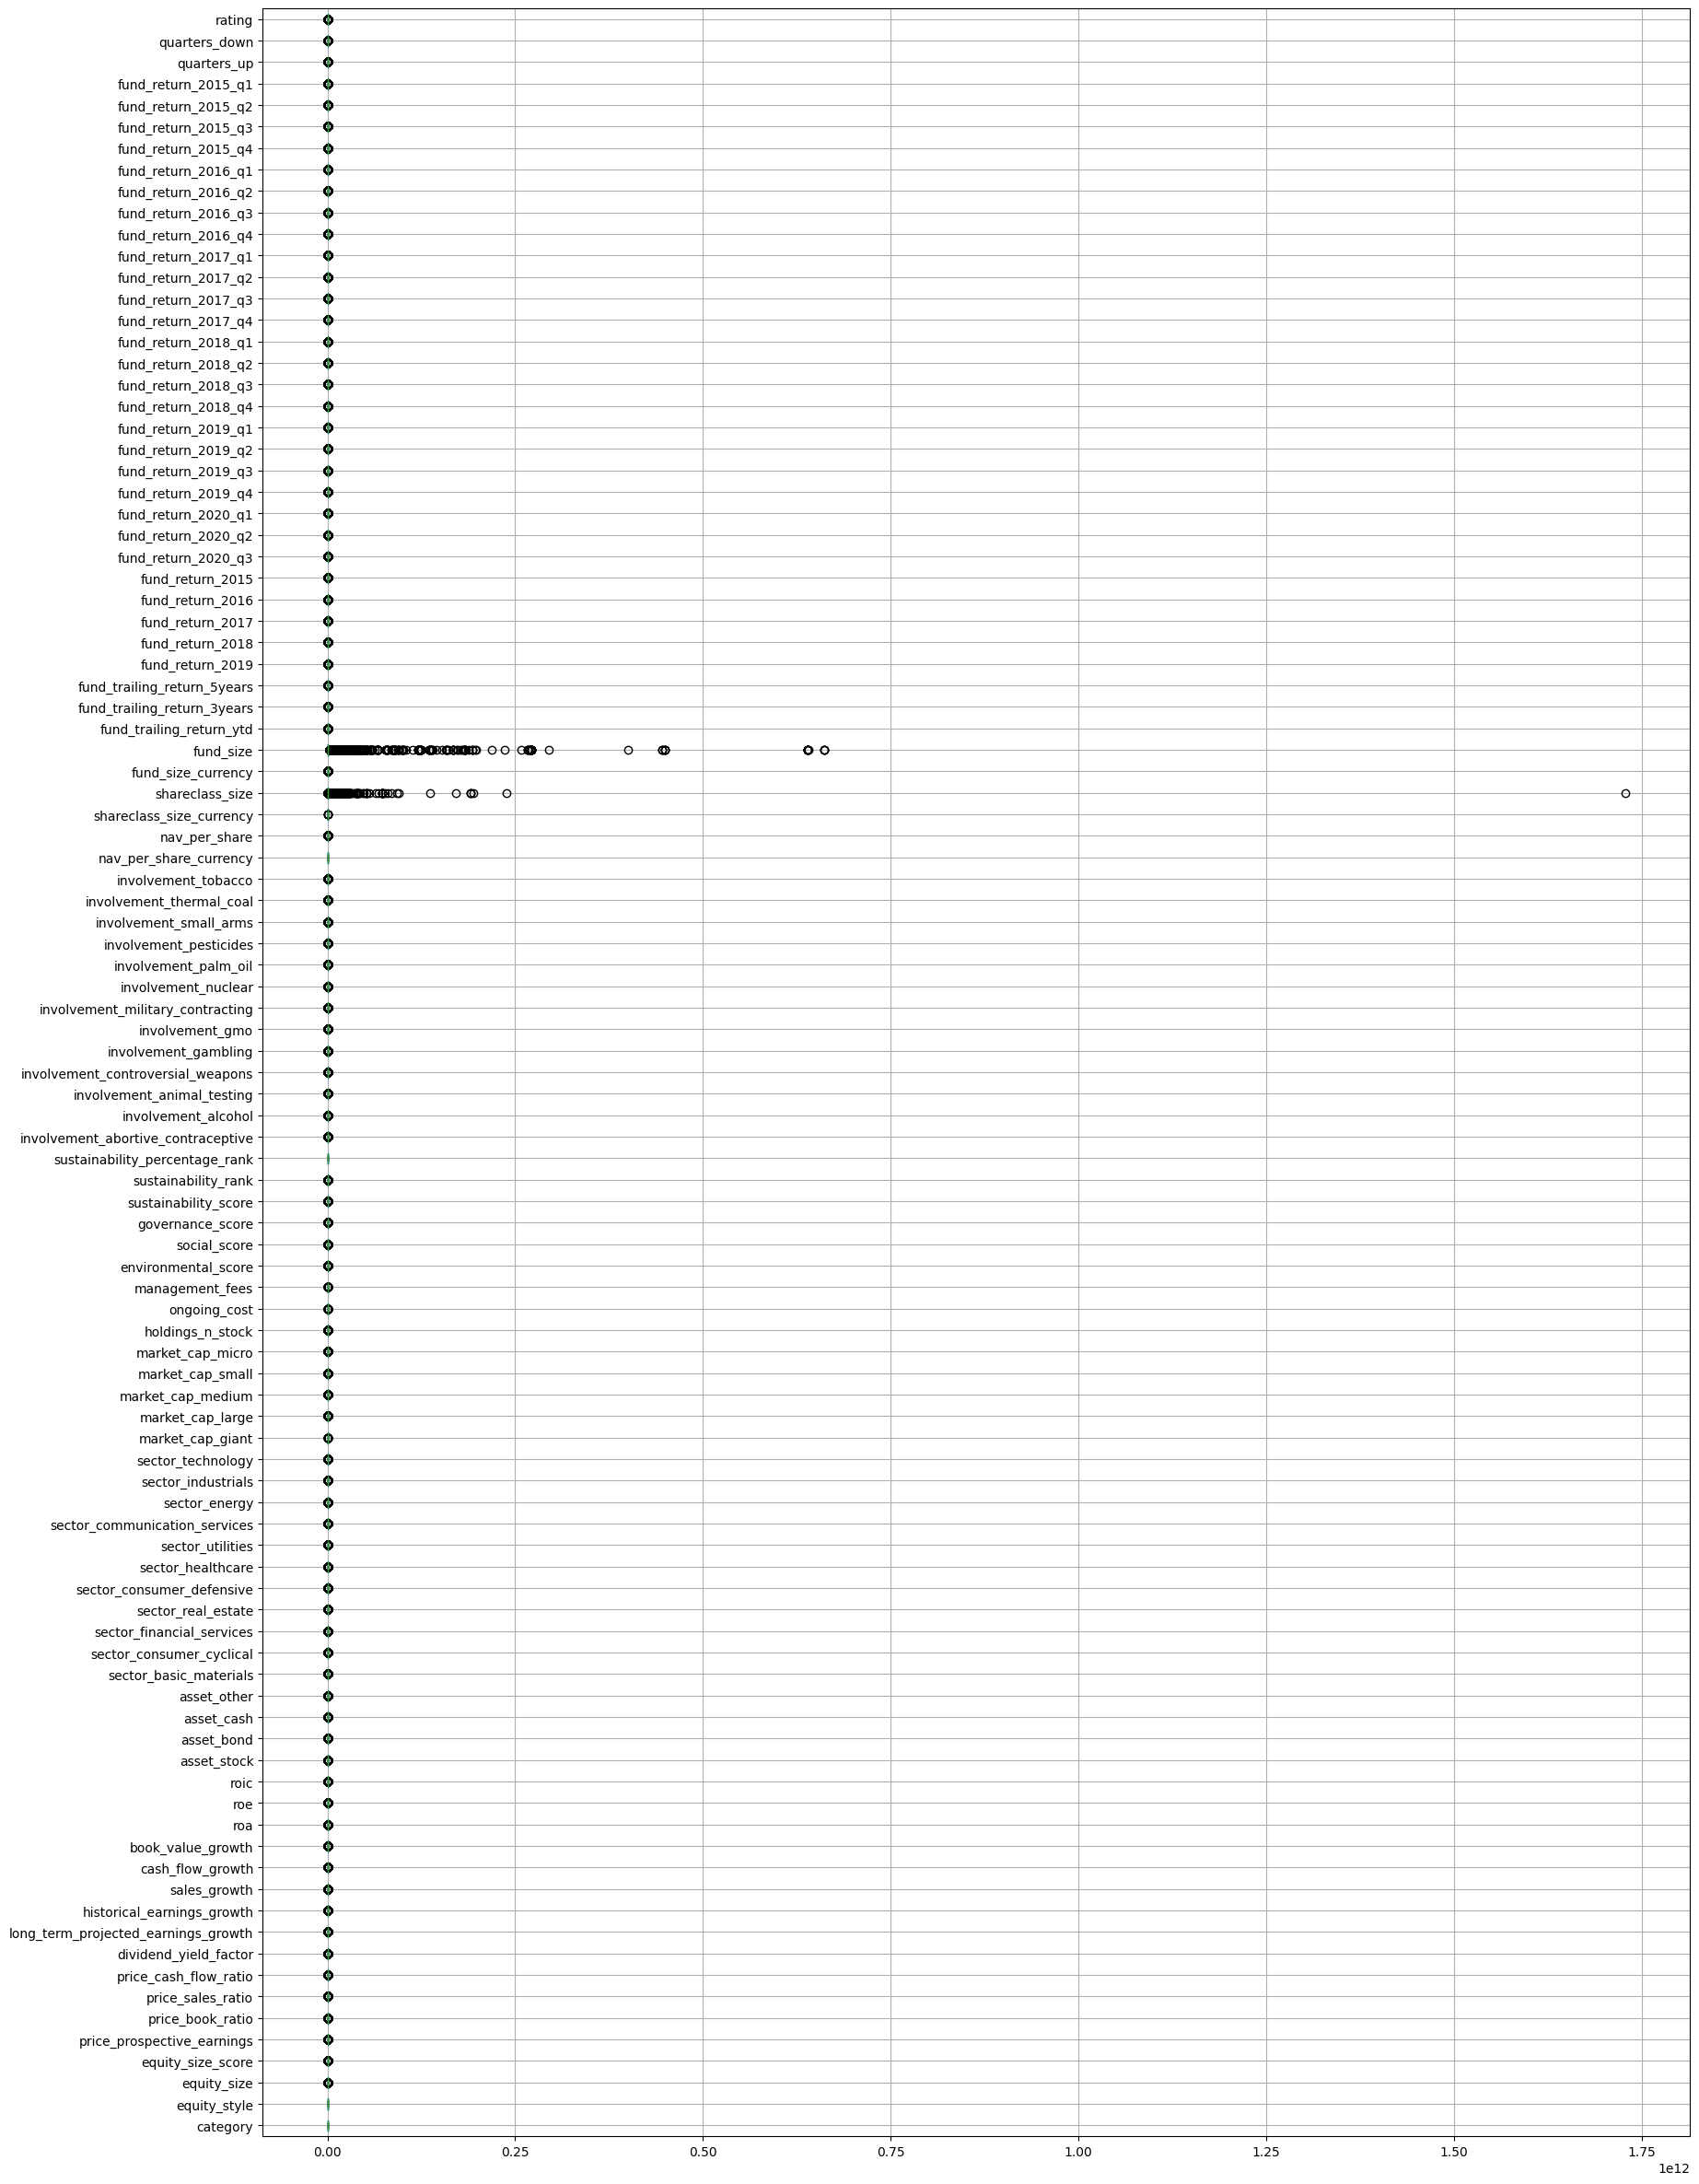

In [48]:
ready_df_imputed.boxplot(vert=False, figsize=(20,30))
plt.show()

In [48]:
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove rows with outliers
    df_cleaned = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df_cleaned

In [49]:
ready_df_imputed = remove_outliers(ready_df_imputed, 'shareclass_size')

In [50]:
ready_df_imputed = remove_outliers(ready_df_imputed, 'fund_size')

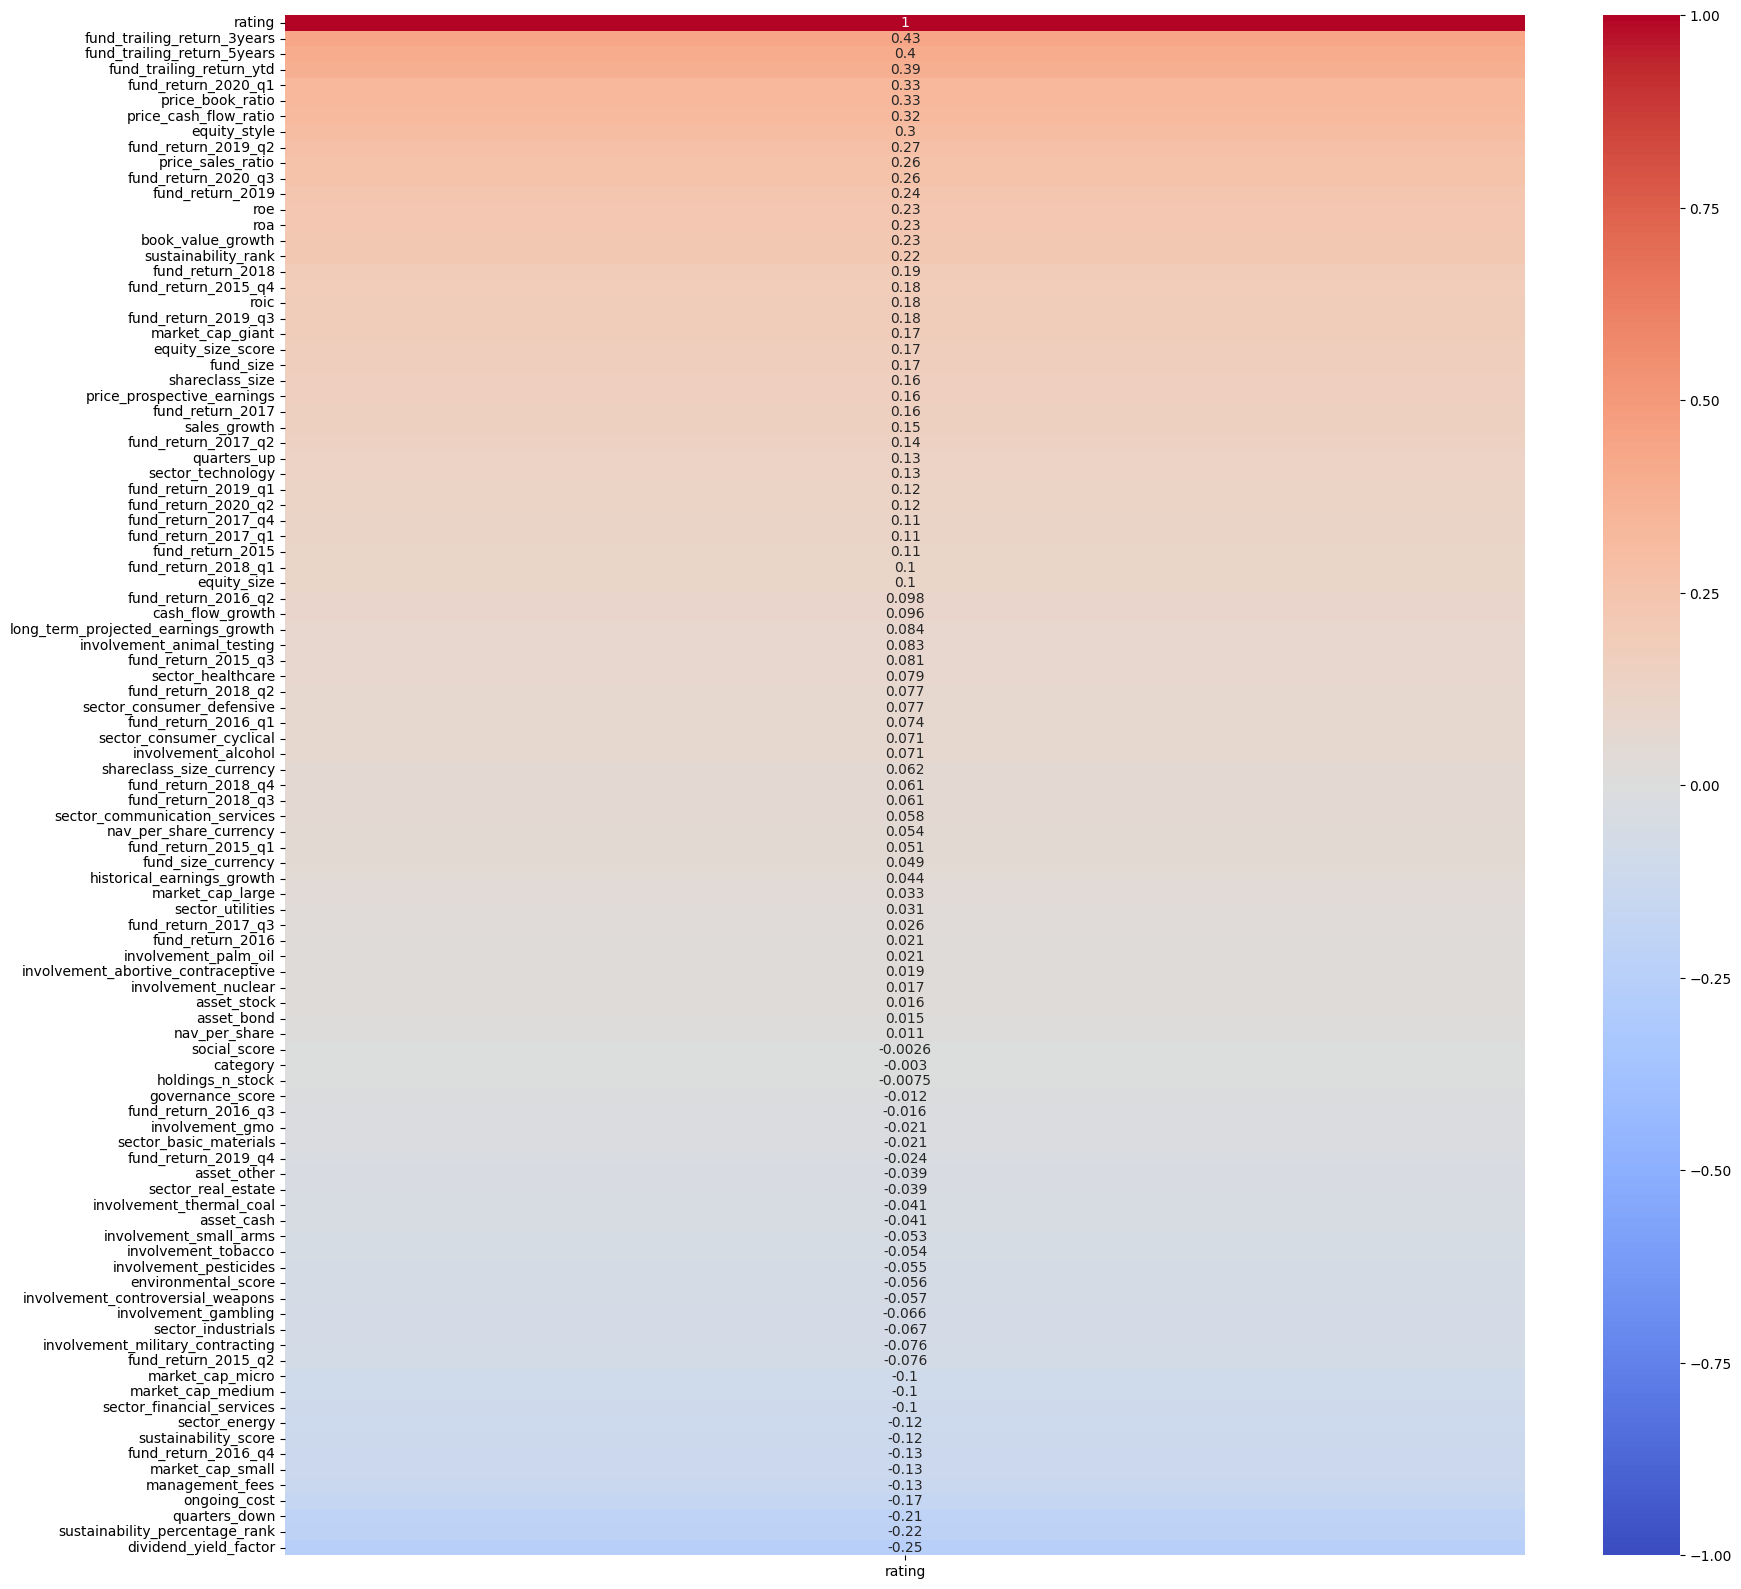

In [24]:
plt.figure(figsize=(20, 20))
correlation_matrix = ready_df_imputed.corr()
sns.heatmap(correlation_matrix[['rating']].sort_values(by='rating', ascending=False), 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1)
plt.show()

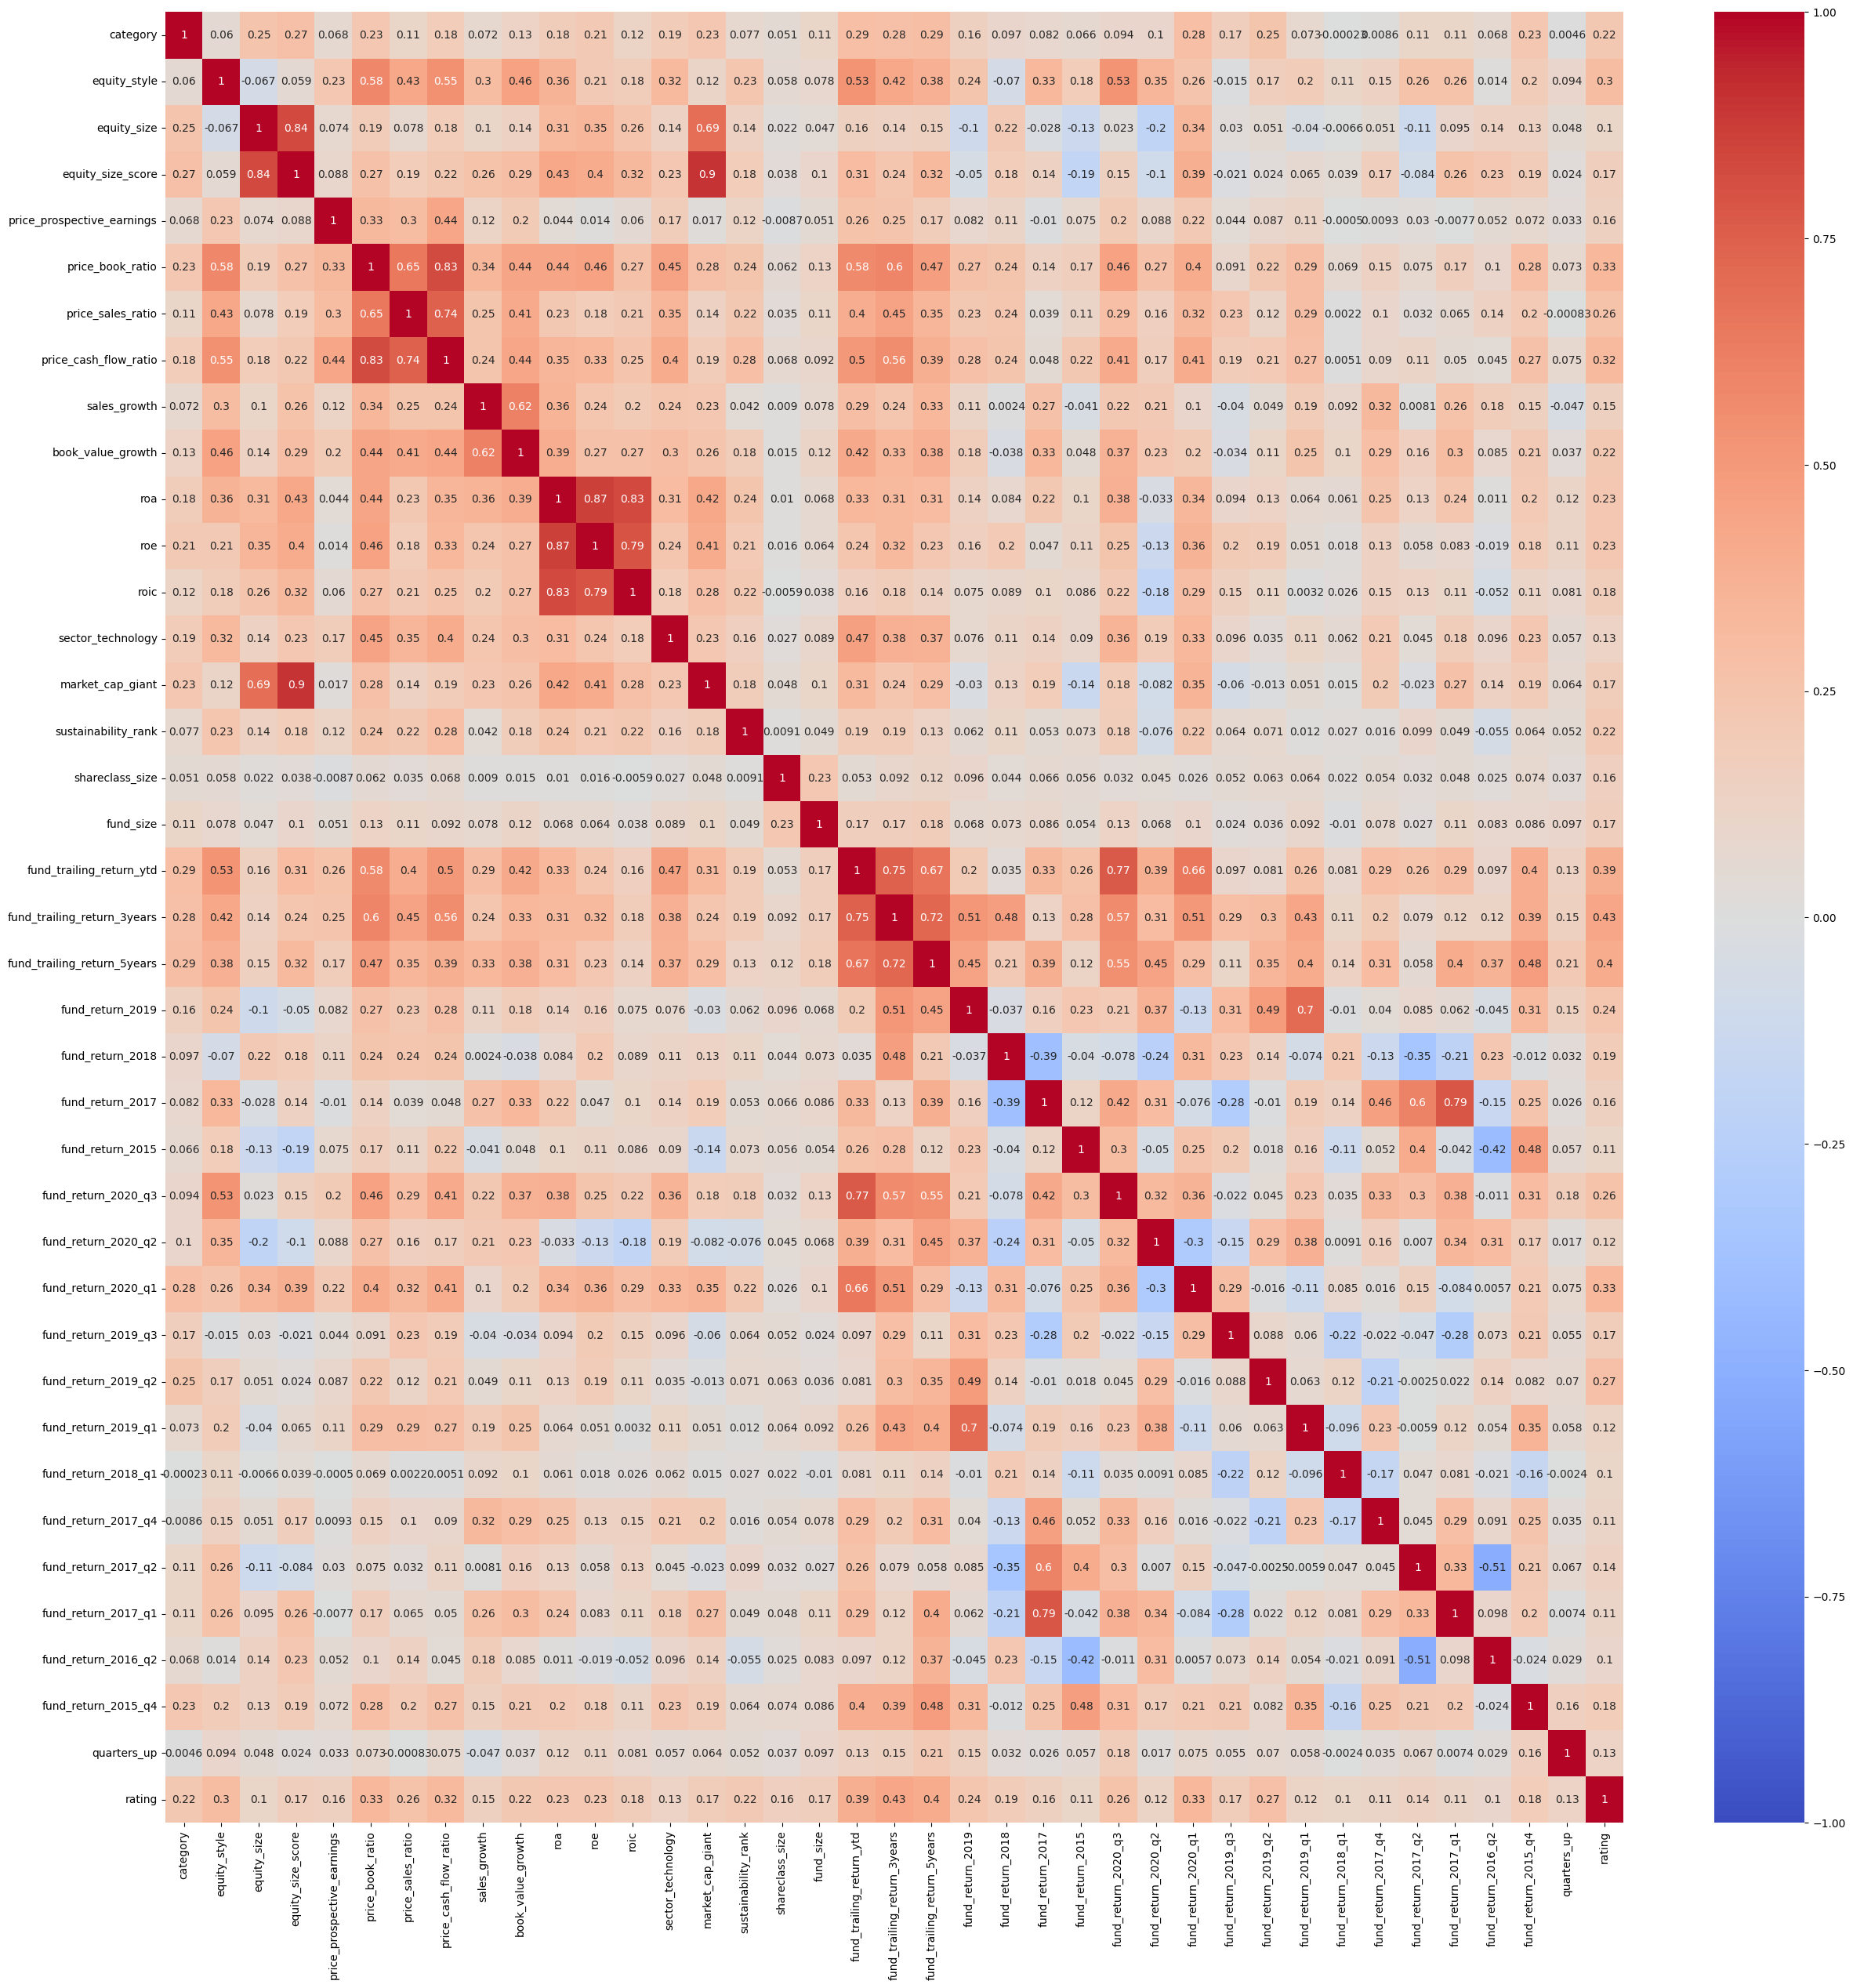

In [280]:
# Assuming your DataFrame is named 'ready_df_imputed'
plt.figure(figsize=(30, 30))

# Calculate the correlation matrix
correlation_matrix = ready_df_imputed.corr()

# Specify the threshold for correlation below which columns will be removed
threshold = 0.1

# Identify columns with correlations below the threshold
low_correlation_columns = correlation_matrix[correlation_matrix['rating'] < threshold].index.tolist()

# Remove the low correlation columns from the DataFrame
ready_df_filtered = ready_df_imputed.drop(low_correlation_columns, axis=1)

test_df_filtered = test_df_imputed.drop(low_correlation_columns, axis=1)

# Create a heatmap of the filtered correlation matrix
sns.heatmap(ready_df_filtered.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

Based on the heatmap above, we can see that some feature has a very high corelation so we can just choose one of them (not implemented)

In [ ]:
# columns_remove = ["maket_cap_giant", "roe"]

In [281]:
ready_df_filtered.shape

(16802, 39)

In [282]:
test_df_filtered.shape

(2802, 38)

In [153]:
ready_df_imputed.head()

,category,equity_style,equity_size,equity_size_score,price_prospective_earnings,price_book_ratio,price_sales_ratio,price_cash_flow_ratio,dividend_yield_factor,long_term_projected_earnings_growth,historical_earnings_growth,sales_growth,cash_flow_growth,book_value_growth,roa,roe,roic,asset_stock,asset_bond,asset_cash,asset_other,sector_basic_materials,sector_consumer_cyclical,sector_financial_services,sector_real_estate,sector_consumer_defensive,sector_healthcare,sector_utilities,sector_communication_services,sector_energy,sector_industrials,sector_technology,market_cap_giant,market_cap_large,market_cap_medium,market_cap_small,market_cap_micro,holdings_n_stock,ongoing_cost,management_fees,environmental_score,social_score,governance_score,sustainability_score,sustainability_rank,sustainability_percentage_rank,involvement_abortive_contraceptive,involvement_alcohol,involvement_animal_testing,involvement_controversial_weapons,involvement_gambling,involvement_gmo,involvement_military_contracting,involvement_nuclear,involvement_palm_oil,involvement_pesticides,involvement_small_arms,involvement_thermal_coal,involvement_tobacco,nav_per_share_currency,nav_per_share,shareclass_size_currency,shareclass_size,fund_size_currency,fund_size,fund_trailing_return_ytd,fund_trailing_return_3years,fund_trailing_return_5years,fund_return_2019,fund_return_2018,fund_return_2017,fund_return_2016,fund_return_2015,fund_return_2020_q3,fund_return_2020_q2,fund_return_2020_q1,fund_return_2019_q4,fund_return_2019_q3,fund_return_2019_q2,fund_return_2019_q1,fund_return_2018_q4,fund_return_2018_q3,fund_return_2018_q2,fund_return_2018_q1,fund_return_2017_q4,fund_return_2017_q3,fund_return_2017_q2,fund_return_2017_q1,fund_return_2016_q4,fund_return_2016_q3,fund_return_2016_q2,fund_return_2016_q1,fund_return_2015_q4,fund_return_2015_q3,fund_return_2015_q2,fund_return_2015_q1,quarters_up,quarters_down,rating
1,35.0,2.0,2.0,124.69,23.06,1.97,1.70,12.07,1.30,9.34,14.300,7.55,8.56,9.59,7.36,14.61,11.33,96.81,0.57,2.63,-0.01,8.17,14.42,18.82,8.686,2.96,15.34,1.590,8.44,3.586,17.32,21.39,1.14,0.00,66.33,32.53,0.00,57.0,0.8400,0.75,5.310,8.850,7.160,26.080,2.0,78.0,3.93,0.00,14.93,0.00,0.00,0.00,4.91,0.00,0.00,2.38,0.00,1.59,0.00,13.0,3.96,13.0,17010000.0,10.0,771790000.0,1.65,6.66,12.090,25.39,-5.72,1.740,41.980,7.120,0.89,17.82,-24.09,0.12,4.68,8.60,10.16,-16.02,6.56,11.32,-5.35,5.29,-1.810,-1.710,0.120,11.940,8.640,9.400,6.720,9.260,-6.20,-4.920,9.93,16.0,7.0,3.0
2,98.0,3.0,3.0,322.70,27.99,3.04,2.71,10.35,0.97,16.87,14.558,13.80,21.53,14.76,7.83,16.35,11.62,95.92,0.00,2.21,1.87,6.35,22.32,10.82,0.440,11.74,3.37,4.384,17.14,4.960,4.39,23.42,62.38,21.08,11.85,3.33,1.37,40.0,1.0182,0.75,4.230,8.380,6.990,24.980,4.0,44.0,0.26,0.00,2.83,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.0,2.32,9.0,30900000.0,8.0,128280000.0,45.43,13.19,18.480,22.29,-19.51,29.120,24.700,-5.990,17.13,27.23,-9.07,6.64,1.42,3.90,8.82,-7.94,-7.33,4.11,-9.37,9.92,0.800,6.430,9.500,-2.930,12.530,6.060,7.640,7.340,-10.01,-10.820,9.13,16.0,7.0,4.0
3,129.0,1.0,3.0,229.67,17.19,1.77,0.75,6.52,2.73,7.77,3.170,3.04,-0.32,1.86,4.68,17.51,8.65,99.98,0.00,0.21,-0.19,3.01,14.47,13.86,1.730,11.37,10.43,1.390,8.46,3.270,16.32,15.68,30.86,33.09,23.26,11.14,1.66,1106.0,0.5500,0.30,4.390,9.910,7.060,23.500,2.0,79.0,7.35,0.12,13.24,1.44,0.31,0.06,2.79,0.96,0.00,0.17,0.41,0.85,0.62,13.0,19.92,13.0,6940000.0,10.0,297460000.0,3.61,7.43,12.890,23.37,-6.10,6.130,38.640,-0.800,4.01,16.15,-22.56,0.69,4.38,5.28,11.49,-13.81,6.07,10.02,-6.65,5.87,0.430,-2.510,2.400,12.260,8.150,8.100,5.640,7.760,-5.85,-7.070,5.21,17.0,6.0,2.0
4,132.0,3.0,2.0,111.36,12.15,1.01,0.62,3.54,2.86,10.02,-14.020,-16.23,-6.55,-2.83,1.86,7.77,2.02,107.14,0.00,-7.14,0.00,19.94,2.45,16.94,1.210,2.83,16.24,4.000,9.42,0.960,15.72,10.28,-0.08,11.04,41.30,38.75,9.00,47.0,1.1300,0.85,3.500,8.520,5.930,23.030,2.0,37.0,9.19,0.00,12.95,0.00,0.00,0.00,3.14,0.00,0.00,0.00,0.00,0.00,0.00,11.0,109.88,12.0,1190000.0,11.0,18800000.0,-1.86,2.22,8.582,20.20,-13.60

In [160]:
columns_not_wanted = ['category','equity_style','equity_size', 'nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency', 'rating']

In [161]:
columns_to_scale = [col for col in ready_df_imputed.columns if col not in columns_not_wanted]

In [129]:
# ready_df_hotted = pd.get_dummies(ready_df_imputed, columns=['equity_style','equity_size', 'nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency'], prefix='category')
# test_df_hotted = pd.get_dummies(test_df_imputed, columns=['category'], prefix='category')


In [146]:
ready_df_hotted = pd.get_dummies(ready_df_imputed, columns=['equity_style'], prefix='style')
test_df_hotted = pd.get_dummies(test_df_imputed, columns=['equity_style'], prefix='style')

In [147]:
ready_df_hotted = pd.get_dummies(ready_df_hotted, columns=['equity_size'], prefix='size')
test_df_hotted = pd.get_dummies(test_df_hotted, columns=['equity_size'], prefix='size')

In [148]:
ready_df_hotted = pd.get_dummies(ready_df_hotted, columns=['nav_per_share_currency'], prefix='nav_currency')
test_df_hotted = pd.get_dummies(test_df_hotted, columns=['nav_per_share_currency'], prefix='nav_currency')

In [149]:
ready_df_hotted = pd.get_dummies(ready_df_hotted, columns=['shareclass_size_currency'], prefix='shareclass_currency')
test_df_hotted = pd.get_dummies(test_df_hotted, columns=['shareclass_size_currency'], prefix='shareclass_currency')

In [150]:
ready_df_hotted = pd.get_dummies(ready_df_hotted, columns=['fund_size_currency'], prefix='fund_currency')
test_df_hotted = pd.get_dummies(test_df_hotted, columns=['fund_size_currency'], prefix='fund_currency')

In [29]:
test_df_imputed.shape

(2802, 98)

In [51]:
from sklearn.preprocessing import PolynomialFeatures


scaler = StandardScaler()

# Memisahkan antara fitur dan target
y = ready_df_imputed['rating']
X = ready_df_imputed.drop(['rating'],axis=1)
# y = ready_df_hotted['rating']
# X = ready_df_hotted.drop(['rating'],axis=1)

# Scaling the features using StandardScaler
X = scaler.fit_transform(X)

X_final = scaler.transform(test_df_imputed)


In [296]:
X.shape

(16802, 98)

In [52]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [74]:
ready_df_filtered.head()

,category,equity_style,price_book_ratio,price_sales_ratio,price_cash_flow_ratio,book_value_growth,roa,roe,sustainability_rank,fund_trailing_return_ytd,fund_trailing_return_3years,fund_trailing_return_5years,fund_return_2019,fund_return_2020_q3,fund_return_2020_q1,fund_return_2019_q2,rating
1,35.0,2.0,1.97,1.70,12.07,9.59,7.36,14.61,2.0,1.65,6.66,12.090,25.39,0.89,-24.09,8.60,3.0
2,98.0,3.0,3.04,2.71,10.35,14.76,7.83,16.35,4.0,45.43,13.19,18.480,22.29,17.13,-9.07,3.90,4.0
3,129.0,1.0,1.77,0.75,6.52,1.86,4.68,17.51,2.0,3.61,7.43,12.890,23.37,4.01,-22.56,5.28,2.0
4,132.0,3.0,1.01,0.62,3.54,-2.83,1.86,7.77,2.0,-1.86,2.22,8.582,20.20,1.36,-27.51,11.95,2.0
7,144.0,2.0,1.96,1.39,10.36,6.97,7.65,19.48,3.6,5.24,3.95,7.630,7.26,-2.69,-3.82,5.41,3.0


In [285]:
ready_df_filtered['rating'].unique()

array([3., 4., 2., 5., 1.])

In [286]:
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.1,
}

In [287]:
from xgboost import XGBClassifier

# Define your XGBoost hyperparameters as needed

y_train_xgb = y_train.astype(int)
y_test_xgb = y_test.astype(int)

xgb_enc = LabelEncoder()

y_train_encoded = xgb_enc.fit_transform(y_train_xgb)
y_test_encoded = xgb_enc.transform(y_test_xgb)

# Create an instance of XGBClassifier
xgb_classifier = XGBClassifier(**xgb_params)

# Fit the XGBClassifier model on the training data
xgb_classifier.fit(X_train, y_train_encoded)

# Make predictions on the test data
xgb_clas_result = xgb_classifier.predict(X_test)


In [276]:
X_final.shape

(2802, 158)

In [274]:
xgb_classifier_submission = XGBClassifier(**xgb_params)

# Fit the XGBClassifier model on the training data

y_xgb_submission = y.astype(int)

xgb_enc_submission = LabelEncoder()

y_xgb_submission = xgb_enc_submission.fit_transform(y_xgb_submission)

xgb_classifier_submission.fit(X, y_xgb_submission)

# Make predictions on the test data
xgb_clas_result = xgb_classifier_submission.predict(X_final)

ValueError: feature_names mismatch: ['category', 'equity_size_score', 'price_prospective_earnings', 'price_book_ratio', 'price_sales_ratio', 'price_cash_flow_ratio', 'dividend_yield_factor', 'long_term_projected_earnings_growth', 'historical_earnings_growth', 'sales_growth', 'cash_flow_growth', 'book_value_growth', 'roa', 'roe', 'roic', 'asset_stock', 'asset_bond', 'asset_cash', 'asset_other', 'sector_basic_materials', 'sector_consumer_cyclical', 'sector_financial_services', 'sector_real_estate', 'sector_consumer_defensive', 'sector_healthcare', 'sector_utilities', 'sector_communication_services', 'sector_energy', 'sector_industrials', 'sector_technology', 'market_cap_giant', 'market_cap_large', 'market_cap_medium', 'market_cap_small', 'market_cap_micro', 'holdings_n_stock', 'ongoing_cost', 'management_fees', 'environmental_score', 'social_score', 'governance_score', 'sustainability_score', 'sustainability_rank', 'sustainability_percentage_rank', 'involvement_abortive_contraceptive', 'involvement_alcohol', 'involvement_animal_testing', 'involvement_controversial_weapons', 'involvement_gambling', 'involvement_gmo', 'involvement_military_contracting', 'involvement_nuclear', 'involvement_palm_oil', 'involvement_pesticides', 'involvement_small_arms', 'involvement_thermal_coal', 'involvement_tobacco', 'nav_per_share', 'shareclass_size', 'fund_size', 'fund_trailing_return_ytd', 'fund_trailing_return_3years', 'fund_trailing_return_5years', 'fund_return_2019', 'fund_return_2018', 'fund_return_2017', 'fund_return_2016', 'fund_return_2015', 'fund_return_2020_q3', 'fund_return_2020_q2', 'fund_return_2020_q1', 'fund_return_2019_q4', 'fund_return_2019_q3', 'fund_return_2019_q2', 'fund_return_2019_q1', 'fund_return_2018_q4', 'fund_return_2018_q3', 'fund_return_2018_q2', 'fund_return_2018_q1', 'fund_return_2017_q4', 'fund_return_2017_q3', 'fund_return_2017_q2', 'fund_return_2017_q1', 'fund_return_2016_q4', 'fund_return_2016_q3', 'fund_return_2016_q2', 'fund_return_2016_q1', 'fund_return_2015_q4', 'fund_return_2015_q3', 'fund_return_2015_q2', 'fund_return_2015_q1', 'quarters_up', 'quarters_down', 'style_1.0', 'style_2.0', 'style_3.0', 'size_1.0', 'size_2.0', 'size_3.0', 'nav_currency_1.0', 'nav_currency_2.0', 'nav_currency_3.0', 'nav_currency_4.0', 'nav_currency_5.0', 'nav_currency_6.0', 'nav_currency_6.8', 'nav_currency_7.0', 'nav_currency_7.8', 'nav_currency_8.0', 'nav_currency_9.0', 'nav_currency_9.8', 'nav_currency_10.0', 'nav_currency_10.4', 'nav_currency_11.0', 'nav_currency_12.0', 'nav_currency_13.0', 'nav_currency_14.0', 'nav_currency_15.0', 'nav_currency_16.0', 'shareclass_currency_1.0', 'shareclass_currency_2.0', 'shareclass_currency_3.0', 'shareclass_currency_4.0', 'shareclass_currency_5.0', 'shareclass_currency_6.0', 'shareclass_currency_7.0', 'shareclass_currency_7.8', 'shareclass_currency_8.0', 'shareclass_currency_9.0', 'shareclass_currency_9.2', 'shareclass_currency_9.6', 'shareclass_currency_9.8', 'shareclass_currency_10.0', 'shareclass_currency_10.2', 'shareclass_currency_10.4', 'shareclass_currency_10.6', 'shareclass_currency_11.0', 'shareclass_currency_11.4', 'shareclass_currency_11.8', 'shareclass_currency_12.0', 'shareclass_currency_12.4', 'shareclass_currency_12.6', 'shareclass_currency_13.0', 'shareclass_currency_14.0', 'fund_currency_1.0', 'fund_currency_3.0', 'fund_currency_4.0', 'fund_currency_5.0', 'fund_currency_6.0', 'fund_currency_7.0', 'fund_currency_8.0', 'fund_currency_8.4', 'fund_currency_8.6', 'fund_currency_8.8', 'fund_currency_9.0', 'fund_currency_9.2', 'fund_currency_9.4', 'fund_currency_9.6', 'fund_currency_9.8', 'fund_currency_10.0', 'fund_currency_11.0', 'fund_currency_12.0', 'fund_currency_13.0'] ['category', 'equity_size_score', 'price_prospective_earnings', 'price_book_ratio', 'price_sales_ratio', 'price_cash_flow_ratio', 'dividend_yield_factor', 'long_term_projected_earnings_growth', 'historical_earnings_growth', 'sales_growth', 'cash_flow_growth', 'book_value_growth', 'roa', 'roe', 'roic', 'asset_stock', 'asset_bond', 'asset_cash', 'asset_other', 'sector_basic_materials', 'sector_consumer_cyclical', 'sector_financial_services', 'sector_real_estate', 'sector_consumer_defensive', 'sector_healthcare', 'sector_utilities', 'sector_communication_services', 'sector_energy', 'sector_industrials', 'sector_technology', 'market_cap_giant', 'market_cap_large', 'market_cap_medium', 'market_cap_small', 'market_cap_micro', 'holdings_n_stock', 'ongoing_cost', 'management_fees', 'environmental_score', 'social_score', 'governance_score', 'sustainability_score', 'sustainability_rank', 'sustainability_percentage_rank', 'involvement_abortive_contraceptive', 'involvement_alcohol', 'involvement_animal_testing', 'involvement_controversial_weapons', 'involvement_gambling', 'involvement_gmo', 'involvement_military_contracting', 'involvement_nuclear', 'involvement_palm_oil', 'involvement_pesticides', 'involvement_small_arms', 'involvement_thermal_coal', 'involvement_tobacco', 'nav_per_share', 'shareclass_size', 'fund_size', 'fund_trailing_return_ytd', 'fund_trailing_return_3years', 'fund_trailing_return_5years', 'fund_return_2019', 'fund_return_2018', 'fund_return_2017', 'fund_return_2016', 'fund_return_2015', 'fund_return_2020_q3', 'fund_return_2020_q2', 'fund_return_2020_q1', 'fund_return_2019_q4', 'fund_return_2019_q3', 'fund_return_2019_q2', 'fund_return_2019_q1', 'fund_return_2018_q4', 'fund_return_2018_q3', 'fund_return_2018_q2', 'fund_return_2018_q1', 'fund_return_2017_q4', 'fund_return_2017_q3', 'fund_return_2017_q2', 'fund_return_2017_q1', 'fund_return_2016_q4', 'fund_return_2016_q3', 'fund_return_2016_q2', 'fund_return_2016_q1', 'fund_return_2015_q4', 'fund_return_2015_q3', 'fund_return_2015_q2', 'fund_return_2015_q1', 'quarters_up', 'quarters_down', 'style_1.0', 'style_2.0', 'style_3.0', 'size_1.0', 'size_2.0', 'size_3.0', 'nav_currency_1.0', 'nav_currency_2.0', 'nav_currency_3.0', 'nav_currency_4.0', 'nav_currency_5.0', 'nav_currency_6.0', 'nav_currency_7.0', 'nav_currency_8.0', 'nav_currency_9.0', 'nav_currency_10.0', 'nav_currency_11.0', 'nav_currency_12.0', 'nav_currency_13.0', 'nav_currency_14.0', 'nav_currency_17.0', 'shareclass_currency_3.0', 'shareclass_currency_5.0', 'shareclass_currency_6.0', 'shareclass_currency_7.0', 'shareclass_currency_8.0', 'shareclass_currency_8.2', 'shareclass_currency_9.0', 'shareclass_currency_9.2', 'shareclass_currency_9.4', 'shareclass_currency_9.6', 'shareclass_currency_9.8', 'shareclass_currency_10.0', 'shareclass_currency_10.2', 'shareclass_currency_10.4', 'shareclass_currency_10.6', 'shareclass_currency_11.0', 'shareclass_currency_12.0', 'shareclass_currency_12.8', 'shareclass_currency_13.0', 'shareclass_currency_14.0', 'shareclass_currency_15.0', 'fund_currency_2.0', 'fund_currency_3.0', 'fund_currency_4.0', 'fund_currency_5.0', 'fund_currency_6.0', 'fund_currency_6.6', 'fund_currency_6.8', 'fund_currency_7.0', 'fund_currency_7.6', 'fund_currency_7.8', 'fund_currency_8.0', 'fund_currency_8.2', 'fund_currency_8.4', 'fund_currency_8.6', 'fund_currency_8.8', 'fund_currency_9.0', 'fund_currency_9.2', 'fund_currency_9.4', 'fund_currency_9.6', 'fund_currency_10.0', 'fund_currency_11.0', 'fund_currency_12.0', 'fund_currency_13.0']
expected shareclass_currency_12.6, fund_currency_1.0, shareclass_currency_7.8, shareclass_currency_11.8, shareclass_currency_1.0, shareclass_currency_11.4, nav_currency_6.8, shareclass_currency_12.4, shareclass_currency_4.0, shareclass_currency_2.0, nav_currency_9.8, fund_currency_9.8, nav_currency_15.0, nav_currency_10.4, nav_currency_7.8, nav_currency_16.0 in input data
training data did not have the following fields: nav_currency_17.0, shareclass_currency_9.4, fund_currency_8.2, fund_currency_7.6, fund_currency_6.6, fund_currency_7.8, shareclass_currency_8.2, shareclass_currency_15.0, shareclass_currency_12.8, fund_currency_6.8, fund_currency_2.0

In [241]:
xgb_clas_result = xgb_enc_submission.inverse_transform(xgb_clas_result)

In [242]:
xgb_clas_result

array([3, 3, 2, ..., 4, 2, 3])

In [288]:
accuracy = accuracy_score(y_test_encoded, xgb_clas_result)
class_report = classification_report(y_test_encoded, xgb_clas_result)
conf_matrix = confusion_matrix(y_test_encoded, xgb_clas_result)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8054150550431419
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.74      0.80       245
           1       0.79      0.78      0.78       705
           2       0.80      0.84      0.82      1263
           3       0.79      0.80      0.79       811
           4       0.85      0.78      0.81       337

    accuracy                           0.81      3361
   macro avg       0.82      0.79      0.80      3361
weighted avg       0.81      0.81      0.81      3361

Confusion Matrix:
 [[ 181   54    8    1    1]
 [  24  552  126    3    0]
 [   0   90 1066  102    5]
 [   0    5  120  646   40]
 [   0    2    8   65  262]]


In [239]:
np.unique(xgb_clas_result)

array([0, 1, 2, 3, 4], dtype=int64)

In [57]:
catboost_params={'nan_mode': 'Min',
 'eval_metric': 'MultiClass',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'eval_fraction': 0,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'use_best_model': False,
 'class_names': [1, 2, 3, 4, 5],
 'random_seed': 123,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'MultiClass',
 'learning_rate': 0.08972600102424622,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 1,
 'bootstrap_type': 'Bayesian',
 'max_leaves': 64}

In [58]:
ccl = CatBoostClassifier(**catboost_params)
ccl.fit(X_train, y_train)
clas_result = ccl.predict(X_test)

0:	learn: 1.5639354	total: 85.9ms	remaining: 1m 25s
1:	learn: 1.5247582	total: 151ms	remaining: 1m 15s
2:	learn: 1.4888457	total: 228ms	remaining: 1m 15s
3:	learn: 1.4585763	total: 292ms	remaining: 1m 12s
4:	learn: 1.4297642	total: 357ms	remaining: 1m 11s
5:	learn: 1.4074451	total: 421ms	remaining: 1m 9s
6:	learn: 1.3880239	total: 483ms	remaining: 1m 8s
7:	learn: 1.3692296	total: 544ms	remaining: 1m 7s
8:	learn: 1.3525142	total: 602ms	remaining: 1m 6s
9:	learn: 1.3368984	total: 660ms	remaining: 1m 5s
10:	learn: 1.3200737	total: 718ms	remaining: 1m 4s
11:	learn: 1.3061869	total: 774ms	remaining: 1m 3s
12:	learn: 1.2936106	total: 831ms	remaining: 1m 3s
13:	learn: 1.2807026	total: 891ms	remaining: 1m 2s
14:	learn: 1.2693590	total: 948ms	remaining: 1m 2s
15:	learn: 1.2588860	total: 1s	remaining: 1m 1s
16:	learn: 1.2499139	total: 1.06s	remaining: 1m 1s
17:	learn: 1.2409254	total: 1.11s	remaining: 1m
18:	learn: 1.2335817	total: 1.17s	remaining: 1m
19:	learn: 1.2230168	total: 1.22s	remaining:

In [302]:
ccl_submission = CatBoostClassifier(**catboost_params)
ccl_submission.fit(X, y)
clas_result_submission = ccl_submission.predict(X_final)

0:	learn: 1.5632121	total: 86.5ms	remaining: 11m 31s
1:	learn: 1.5242305	total: 150ms	remaining: 10m 1s
2:	learn: 1.4883611	total: 202ms	remaining: 8m 58s
3:	learn: 1.4576499	total: 254ms	remaining: 8m 28s
4:	learn: 1.4286328	total: 302ms	remaining: 8m 3s
5:	learn: 1.4050738	total: 361ms	remaining: 8m
6:	learn: 1.3862080	total: 410ms	remaining: 7m 47s
7:	learn: 1.3679141	total: 462ms	remaining: 7m 41s
8:	learn: 1.3481346	total: 515ms	remaining: 7m 37s
9:	learn: 1.3311049	total: 580ms	remaining: 7m 43s
10:	learn: 1.3155520	total: 665ms	remaining: 8m 2s
11:	learn: 1.3009732	total: 738ms	remaining: 8m 11s
12:	learn: 1.2897161	total: 793ms	remaining: 8m 7s
13:	learn: 1.2776053	total: 843ms	remaining: 8m
14:	learn: 1.2680919	total: 894ms	remaining: 7m 56s
15:	learn: 1.2589749	total: 952ms	remaining: 7m 55s
16:	learn: 1.2474242	total: 1.02s	remaining: 7m 57s
17:	learn: 1.2384190	total: 1.07s	remaining: 7m 54s
18:	learn: 1.2295883	total: 1.13s	remaining: 7m 53s
19:	learn: 1.2224319	total: 1.1

In [60]:
from sklearn.model_selection import StratifiedKFold, cross_val_score


accuracy = accuracy_score(y_test, clas_result)
class_report = classification_report(y_test, clas_result)
conf_matrix = confusion_matrix(y_test, clas_result)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(f"Cross Validation Score: {np.mean(cross_val_score(ccl, X_train, y_train, cv=stratified_cv))}")


Accuracy: 0.7828027372805713
Classification Report:
               precision    recall  f1-score   support

         1.0       0.88      0.70      0.78       245
         2.0       0.75      0.72      0.74       705
         3.0       0.77      0.84      0.80      1263
         4.0       0.78      0.78      0.78       811
         5.0       0.86      0.76      0.80       337

    accuracy                           0.78      3361
   macro avg       0.81      0.76      0.78      3361
weighted avg       0.79      0.78      0.78      3361

Confusion Matrix:
 [[ 172   66    6    1    0]
 [  24  511  163    7    0]
 [   0   97 1057  105    4]
 [   0    8  129  636   38]
 [   0    1   11   70  255]]
0:	learn: 1.5650659	total: 56ms	remaining: 55.9s
1:	learn: 1.5279188	total: 103ms	remaining: 51.4s
2:	learn: 1.4921452	total: 149ms	remaining: 49.5s
3:	learn: 1.4619861	total: 192ms	remaining: 47.8s
4:	learn: 1.4343452	total: 240ms	remaining: 47.7s
5:	learn: 1.4117663	total: 283ms	remaining: 46.8s

In [303]:
clas_result_submission

array([[3],
       [3],
       [2],
       ...,
       [4],
       [2],
       [3]], dtype=int64)

In [243]:
eim_test = pd.read_csv('EIM_test.csv')

clas_result_series = pd.Series(clas_result_submission.flatten())

prediction_df = pd.DataFrame({
    "ticker": eim_test["ticker"],
    "rating": clas_result_series
})

prediction_df.to_csv('ClassificationPrediction.csv', index=False)



In [30]:
from sklearn.preprocessing import PolynomialFeatures


scaler = StandardScaler()

# Memisahkan antara fitur dan target
y = ready_df_imputed['long_term_projected_earnings_growth']
X = ready_df_imputed.drop(['long_term_projected_earnings_growth'],axis=1)
# y = ready_df_hotted['rating']
# X = ready_df_hotted.drop(['rating'],axis=1)

# Scaling the features using StandardScaler
X = scaler.fit_transform(X)

X_final = scaler.transform(test_df_imputed)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- long_term_projected_earnings_growth
Feature names seen at fit time, yet now missing:
- rating
